
--- CONSOLIDATED BLOCK 1: Data Preprocessing and Exploration ---
Using device for audio processing and models: cuda

--- 2. Loading RAVDESS Data and Extracting Metadata ---
Scanning RAVDESS audio files in: c:\Users\Suyas\Downloads\audio analysis\audio_speech_actors_01-24


Processing Actors:   0%|          | 0/24 [00:00<?, ?it/s]


Loaded 1440 audio files from RAVDESS.
First 5 rows of RAVDESS dataset:
                                                path emotion_id emotion_label  \
0  c:\Users\Suyas\Downloads\audio analysis\audio_...         01       neutral   
1  c:\Users\Suyas\Downloads\audio analysis\audio_...         01       neutral   
2  c:\Users\Suyas\Downloads\audio analysis\audio_...         01       neutral   
3  c:\Users\Suyas\Downloads\audio analysis\audio_...         01       neutral   
4  c:\Users\Suyas\Downloads\audio analysis\audio_...         02          calm   

  actor_id gender  
0       01   male  
1       01   male  
2       01   male  
3       01   male  
4       01   male  

Emotion distribution in dataset:
emotion_label
calm         192
happy        192
sad          192
angry        192
disgust      192
fearful      192
surprised    192
neutral       96
Name: count, dtype: int64

Numeric emotion labels mapping: {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 

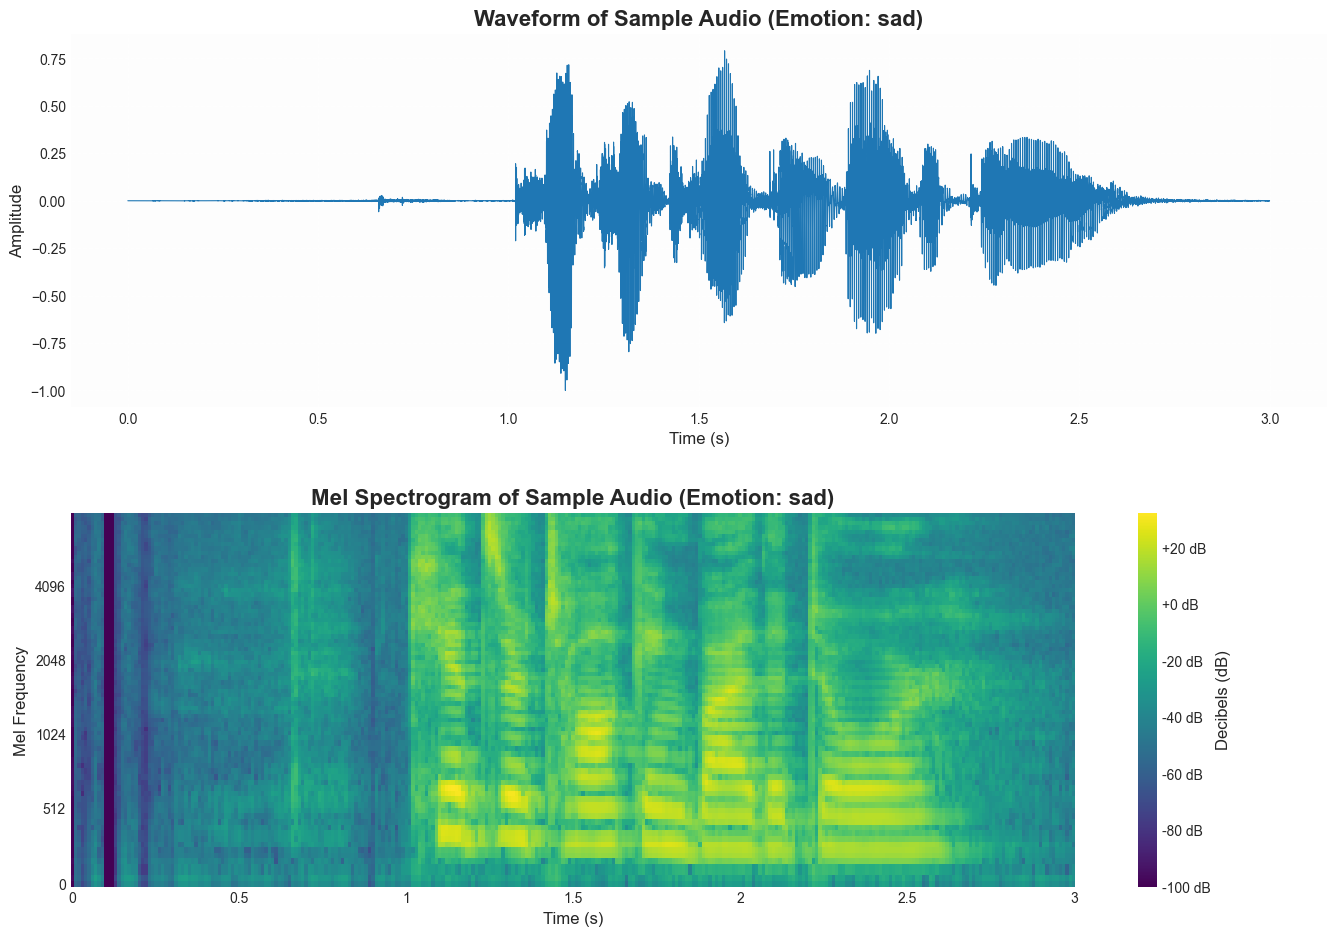

Waveform and Mel Spectrogram of a sample audio file visualized.

--- 6. Enhanced Data Visualization: Dataset Characteristics ---

--- Plotting Emotion Distribution Across Genders ---


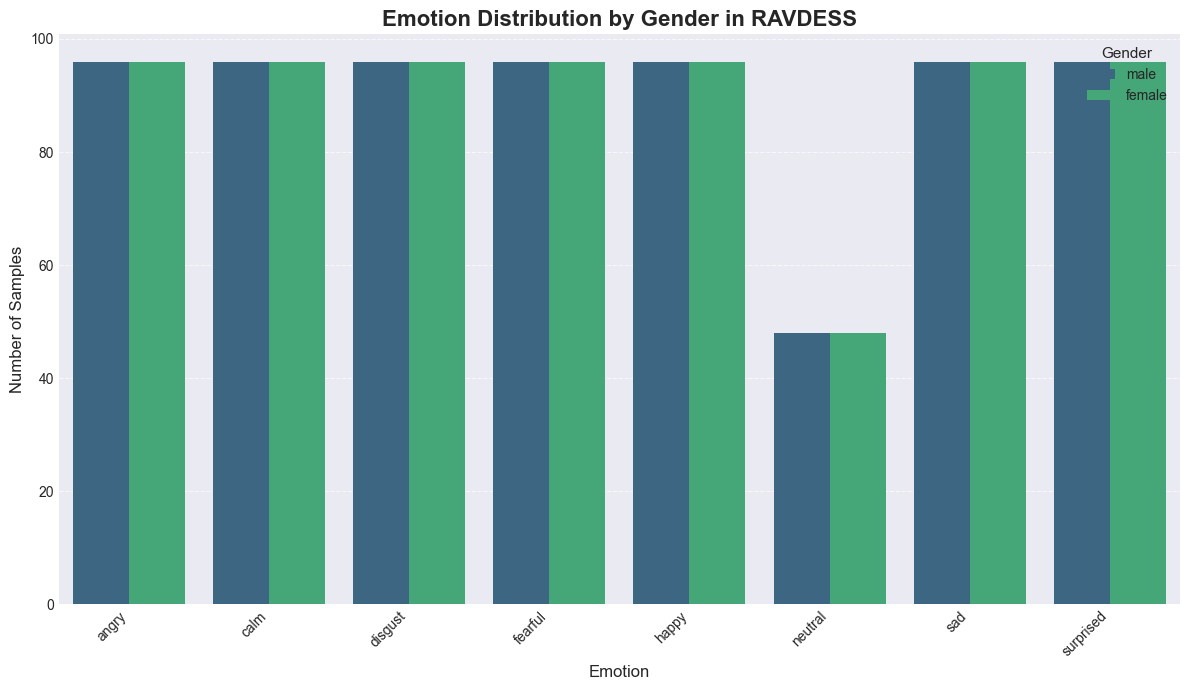


--- Visualizing Mel Spectrograms for Different Emotions ---


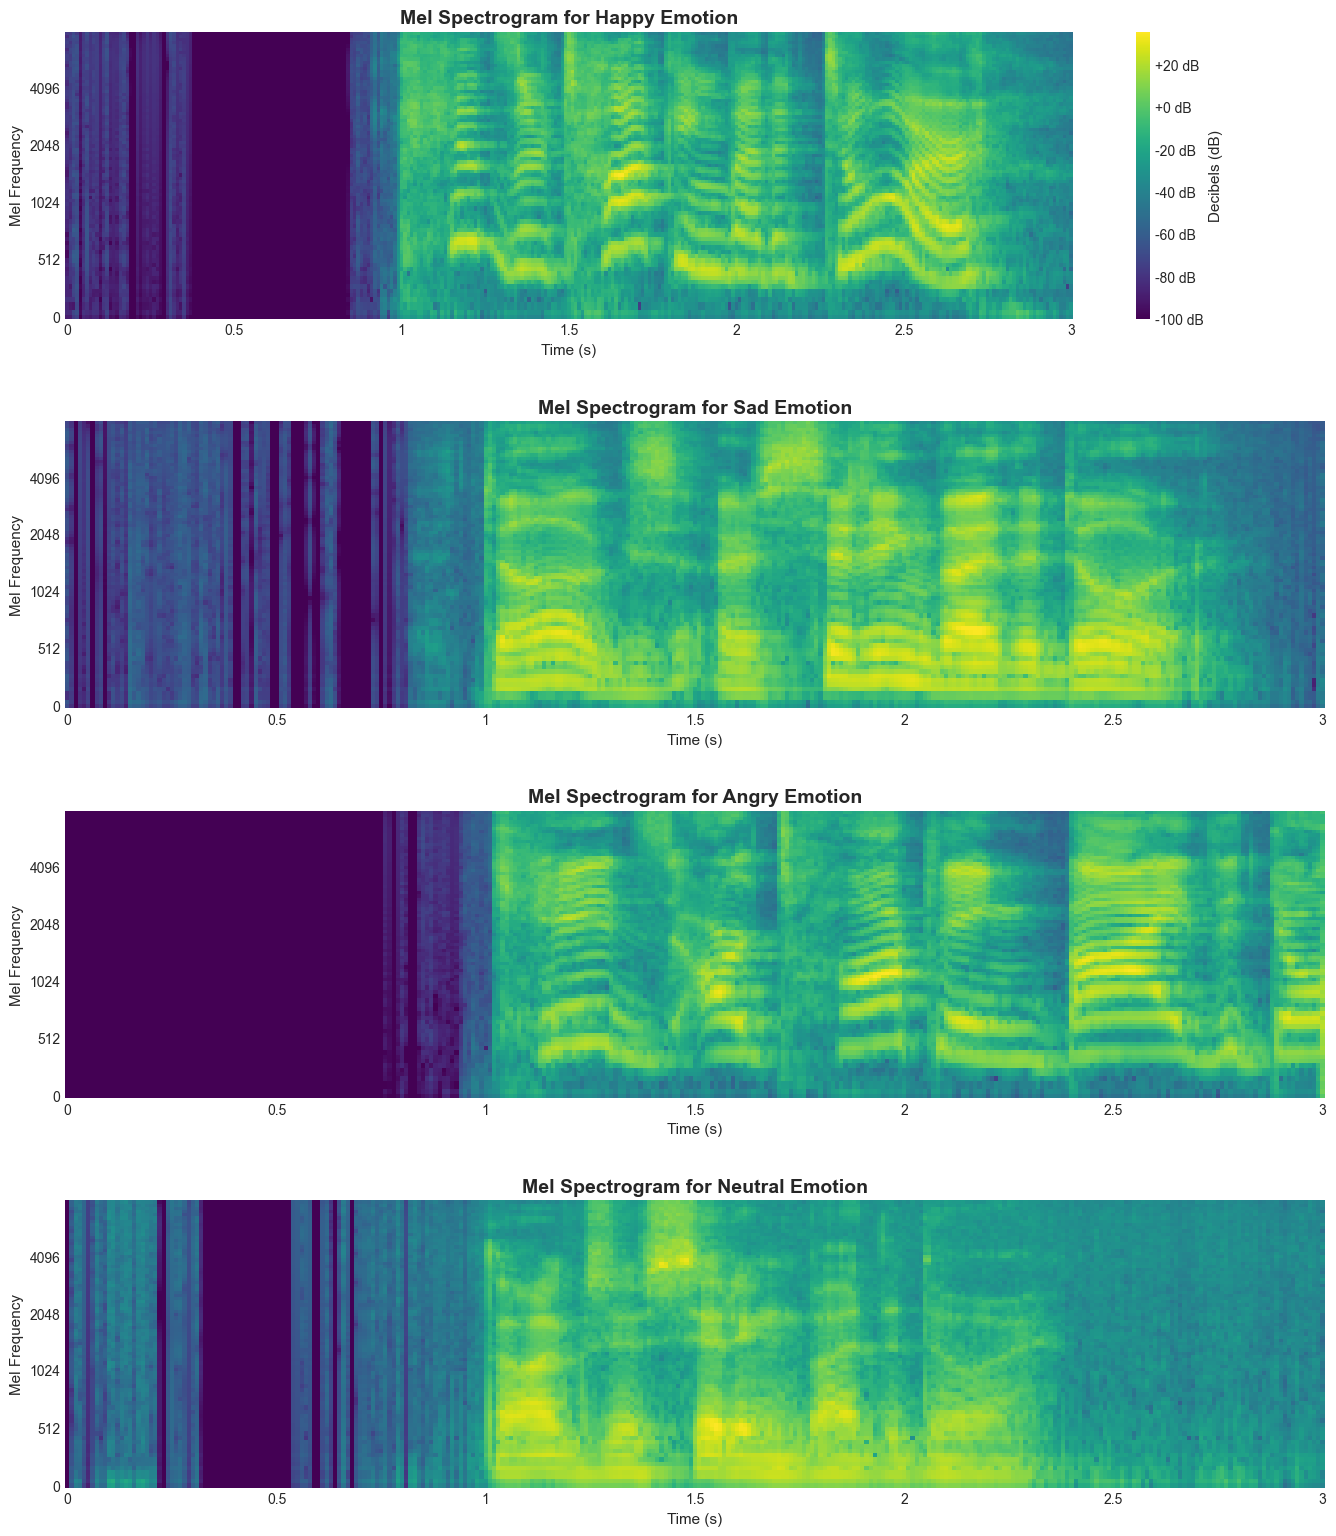


--- Plotting Gender Distribution ---


C:\Users\Suyas\AppData\Local\Temp\ipykernel_6892\3450233912.py:378: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ravdess_df, x='gender', palette='pastel')


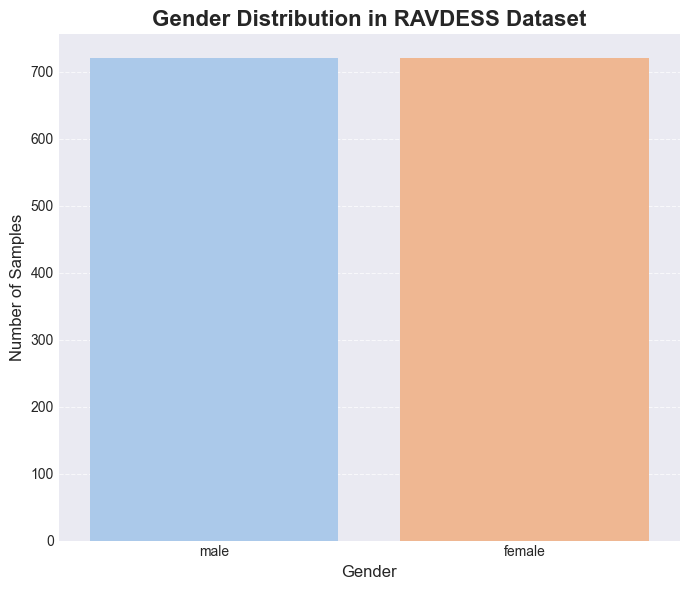


--- CONSOLIDATED BLOCK 1: Data Preprocessing and Exploration Complete ---
All initial setup, data loading, preprocessing, and exploratory visualizations are done.
The dataset is split and ready for model training. Global configuration is in `config`.
Emotion class information is in `emotion_label_to_id`, `num_audio_classes`, `class_weights_tensor`.


In [ ]:
print("\n" + "="*80)
print("--- CONSOLIDATED BLOCK 1: Data Preprocessing and Exploration ---")
print("="*80)

# --- 0. Centralized Configuration Class ---
class AudioConfig:
    RANDOM_SEED = 42
    # Audio Processing Parameters
    TARGET_SAMPLE_RATE = 16000  # Hz (Target sample rate for all processing)
    N_MELS = 80         # Number of mel bands for MFCCs/Mel Spectrograms
    N_FFT = 400          # Window size for FFT (e.g., 25ms at 16kHz)
    HOP_LENGTH = 160     # Hop length for FFT (e.g., 10ms at 16kHz)
    AUDIO_DURATION = 3   # seconds (for fixed-length clips, padding/truncating)
    MAX_SEQUENCE_LENGTH = None # Will be calculated dynamically for RNNs based on AUDIO_DURATION and HOP_LENGTH

    # Model Training Parameters (CNN)
    BATCH_SIZE = 32
    NUM_WORKERS = 0 # Set to 0 for Jupyter notebooks on Windows to avoid multiprocessing issues
    NUM_EPOCHS_CNN = 20
    LEARNING_RATE_CNN = 0.001
    CNN_DROPOUT = 0.3

    # Model Training Parameters (RNN/LSTM)
    NUM_EPOCHS_RNN = 20
    LEARNING_RATE_RNN = 0.001
    LSTM_HIDDEN_SIZE = 128
    LSTM_NUM_LAYERS = 2
    LSTM_DROPOUT = 0.4
    LSTM_BIDIRECTIONAL = True

    # Model Training Parameters (Hybrid - CNN-LSTM)
    NUM_EPOCHS_HYBRID = 35
    LEARNING_RATE_HYBRID = 0.0003
    HYBRID_CNN_DROPOUT = 0.3
    HYBRID_LSTM_DROPOUT = 0.4
    HYBRID_LSTM_HIDDEN_SIZE = 128
    HYBRID_LSTM_NUM_LAYERS = 2
    HYBRID_LSTM_BIDIRECTIONAL = True


    # Paths
    RAVDESS_ROOT_DIR = "." # Current directory
    AUDIO_DATA_DIR = "audio_speech_actors_01-24" # Folder name within RAVDESS_ROOT_DIR

# Instantiate the configuration
config = AudioConfig()

# --- 1. Import Necessary Libraries ---
import torch
import torchaudio
import torchaudio.transforms as T
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import re # For regex to parse filenames
from tqdm.notebook import tqdm # For progress bars
from sklearn.model_selection import train_test_split # For splitting the dataset
import torch.nn.functional as F # For padding
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import seaborn as sns
import copy # For deep copying model state dict
from sklearn.preprocessing import label_binarize # For ROC curves

# Ensure output device for plots is inline
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid') # Set a consistent style for plots

# Set a random seed for reproducibility
np.random.seed(config.RANDOM_SEED)
torch.manual_seed(config.RANDOM_SEED)
random.seed(config.RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set device to GPU if available, otherwise CPU
audio_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device for audio processing and models: {audio_device}")

# --- 2. RAVDESS Data Loading and Metadata Extraction ---
print("\n--- 2. Loading RAVDESS Data and Extracting Metadata ---")
ravdess_data = []
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

audio_speech_dir = os.path.join(config.RAVDESS_ROOT_DIR, config.AUDIO_DATA_DIR)

if not os.path.exists(audio_speech_dir):
    raise FileNotFoundError(f"RAVDESS directory not found at: {os.path.abspath(audio_speech_dir)}\n"
                            "Please ensure 'audio_speech_actors_01-24' is in the same folder as this script.")

print(f"Scanning RAVDESS audio files in: {os.path.abspath(audio_speech_dir)}")

for actor_folder in tqdm(sorted(os.listdir(audio_speech_dir)), desc="Processing Actors"):
    actor_path = os.path.join(audio_speech_dir, actor_folder)
    if not os.path.isdir(actor_path):
        continue

    filename_pattern = re.compile(r'(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})\.wav')

    for filename in os.listdir(actor_path):
        if filename.endswith(".wav"):
            match = filename_pattern.match(filename)
            if match:
                parts = match.groups()
                modality_id, vocal_channel_id, emotion_id, intensity_id, statement_id, repetition_id, actor_id = parts

                emotion_label = emotion_map.get(emotion_id, 'unknown')
                gender = 'male' if int(actor_id) % 2 == 1 else 'female' # Actors 1-12 are male, 13-24 are female

                full_audio_path = os.path.abspath(os.path.join(actor_path, filename))

                ravdess_data.append({
                    'path': full_audio_path,
                    'emotion_id': emotion_id,
                    'emotion_label': emotion_label,
                    'actor_id': actor_id,
                    'gender': gender
                })

ravdess_df = pd.DataFrame(ravdess_data)
print(f"\nLoaded {len(ravdess_df)} audio files from RAVDESS.")
print("First 5 rows of RAVDESS dataset:")
print(ravdess_df.head())
print("\nEmotion distribution in dataset:")
print(ravdess_df['emotion_label'].value_counts())

# Map emotion labels to numerical IDs for training
emotion_class_names = sorted(ravdess_df['emotion_label'].unique())
emotion_label_to_id = {name: i for i, name in enumerate(emotion_class_names)}
ravdess_df['emotion_id_numeric'] = ravdess_df['emotion_label'].map(emotion_label_to_id)
num_audio_classes = len(emotion_class_names) # Define globally for models

print(f"\nNumeric emotion labels mapping: {emotion_label_to_id}")
print(f"Number of emotion classes: {num_audio_classes}")

# --- Calculate class weights for imbalanced datasets (useful for CrossEntropyLoss) ---
class_counts = ravdess_df['emotion_id_numeric'].value_counts().sort_index().values
class_weights_tensor = 1.0 / torch.tensor(class_counts, dtype=torch.float)
class_weights_tensor = class_weights_tensor / class_weights_tensor.sum() * len(class_counts) # Normalize
class_weights_tensor = class_weights_tensor.to(audio_device)
print(f"Calculated class weights for CrossEntropyLoss: {class_weights_tensor.cpu().numpy()}")

# --- 3. Split Dataset into Training, Validation, and Test Sets ---
print("\n--- 3. Splitting RAVDESS Dataset into Train, Validation, Test ---")
train_val_df, test_df_audio = train_test_split(
    ravdess_df, test_size=0.15, random_state=config.RANDOM_SEED, stratify=ravdess_df['emotion_id_numeric']
)
train_df_audio, val_df_audio = train_test_split(
    train_val_df, test_size=0.176, random_state=config.RANDOM_SEED, stratify=train_val_df['emotion_id_numeric']
) # 0.176 of 0.85 approx 0.15 of total (~70/15/15 split)

print(f"Total RAVDESS samples: {len(ravdess_df)}")
print(f"Train samples: {len(train_df_audio)}")
print(f"Validation samples: {len(val_df_audio)}")
print(f"Test samples: {len(test_df_audio)}")

# --- 4. Define the RAVDESS_AudioDataset Class ---
class RAVDESS_AudioDataset(Dataset):
    def __init__(self, dataframe, config, device, emotion_label_to_id, feature_type='mel_spectrogram'):
        self.dataframe = dataframe
        self.config = config
        self.device = device
        self.emotion_label_to_id = emotion_label_to_id
        self.class_names = list(emotion_label_to_id.keys())
        self.feature_type = feature_type
        self.target_num_samples = int(config.AUDIO_DURATION * config.TARGET_SAMPLE_RATE)

        # Initialize torchaudio transforms
        self.resampler = T.Resample(orig_freq=48000, new_freq=self.config.TARGET_SAMPLE_RATE).to(self.device)
        self.mel_spectrogram_transform = T.MelSpectrogram(
            sample_rate=self.config.TARGET_SAMPLE_RATE,
            n_fft=self.config.N_FFT,
            hop_length=self.config.HOP_LENGTH,
            n_mels=self.config.N_MELS
        ).to(self.device)
        self.mfcc_transform = T.MFCC(
            sample_rate=self.config.TARGET_SAMPLE_RATE,
            n_mfcc=self.config.N_MELS, # Use n_mels for consistency in feature dimension
            melkwargs={
                'n_fft': self.config.N_FFT,
                'hop_length': self.config.HOP_LENGTH,
                'n_mels': self.config.N_MELS
            }
        ).to(self.device)
        self.amplitude_to_db = T.AmplitudeToDB().to(self.device)

        # Calculate max_sequence_length for RNNs if not set
        if self.feature_type in ['mfcc', 'mel_spectrogram'] and config.MAX_SEQUENCE_LENGTH is None:
            # Estimate time frames: (target_num_samples / hop_length)
            # A more precise way would be to compute for a dummy waveform, but this is a good estimate.
            estimated_time_frames = int(target_num_samples / config.HOP_LENGTH)
            # MelSpectrogram output size (n_mels, time_frames). MFCC is similar.
            config.MAX_SEQUENCE_LENGTH = estimated_time_frames
            print(f"Dynamically set config.MAX_SEQUENCE_LENGTH for RNNs: {config.MAX_SEQUENCE_LENGTH}")


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        audio_path = self.dataframe.iloc[idx]['path']
        emotion_label = self.dataframe.iloc[idx]['emotion_label']
        numeric_label = self.emotion_label_to_id[emotion_label]

        waveform, sr = torchaudio.load(audio_path)
        waveform = waveform.to(self.device)

        if sr != self.config.TARGET_SAMPLE_RATE:
            waveform = self.resampler(waveform)

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        waveform = waveform / torch.max(torch.abs(waveform))

        if waveform.shape[1] < self.target_num_samples:
            padding = self.target_num_samples - waveform.shape[1]
            waveform = F.pad(waveform, (0, padding), 'constant', 0)
        elif waveform.shape[1] > self.target_num_samples:
            waveform = waveform[:, :self.target_num_samples]

        if self.feature_type == 'mel_spectrogram':
            features = self.mel_spectrogram_transform(waveform)
            features = self.amplitude_to_db(features)
            if features.dim() == 2:
                 features = features.unsqueeze(0)
        elif self.feature_type == 'mfcc':
            features = self.mfcc_transform(waveform)
            if features.dim() == 3:
                features = features.squeeze(0)
            features = features.permute(1, 0) # (time_frames, n_mfcc)
        else:
            raise ValueError(f"Unknown feature_type: {self.feature_type}. Choose 'mel_spectrogram' or 'mfcc'.")

        return features, torch.tensor(numeric_label, dtype=torch.long)

print("\n--- 4. RAVDESS_AudioDataset class defined ---")
print("This custom Dataset handles loading, preprocessing, and feature extraction (Mel Spectrograms or MFCCs).")


# --- 5. Initial Data Visualization of Waveform and Mel Spectrogram ---
print("\n--- 5. Initial Visualization: Sample Waveform and Mel Spectrogram ---")
sample_idx = random.randint(0, len(test_df_audio) - 1)
sample_audio_path = test_df_audio.iloc[sample_idx]['path']
sample_label = test_df_audio.iloc[sample_idx]['emotion_label']

waveform_orig, sr_orig = torchaudio.load(sample_audio_path)
waveform = waveform_orig.to(audio_device)
if sr_orig != config.TARGET_SAMPLE_RATE:
    resampler = T.Resample(orig_freq=sr_orig, new_freq=config.TARGET_SAMPLE_RATE).to(audio_device)
    waveform = resampler(waveform)
    sr_processed = config.TARGET_SAMPLE_RATE
else:
    sr_processed = sr_orig
if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)
waveform = waveform / torch.max(torch.abs(waveform))
target_num_samples = int(config.AUDIO_DURATION * config.TARGET_SAMPLE_RATE)
if waveform.shape[1] < target_num_samples:
    padding = target_num_samples - waveform.shape[1]
    waveform = F.pad(waveform, (0, padding), 'constant', 0)
elif waveform.shape[1] > target_num_samples:
    waveform = waveform[:, :target_num_samples]

mel_spectrogram_transform_vis = T.MelSpectrogram(
    sample_rate=config.TARGET_SAMPLE_RATE,
    n_fft=config.N_FFT,
    hop_length=config.HOP_LENGTH,
    n_mels=config.N_MELS
).to(audio_device)
mel_spectrogram = mel_spectrogram_transform_vis(waveform)
mel_spectrogram_db = T.AmplitudeToDB()(mel_spectrogram)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))
time = np.linspace(0, config.AUDIO_DURATION, waveform.shape[1])
axes[0].plot(time, waveform.squeeze().cpu().numpy(), color='#1f77b4', linewidth=0.8)
axes[0].set_title(f'Waveform of Sample Audio (Emotion: {sample_label})', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Time (s)', fontsize=12)
axes[0].set_ylabel('Amplitude', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_facecolor('#fdfdfd')

librosa.display.specshow(mel_spectrogram_db.squeeze().cpu().numpy(),
                         sr=config.TARGET_SAMPLE_RATE, x_axis='time', y_axis='mel',
                         hop_length=config.HOP_LENGTH, cmap='viridis', ax=axes[1])
cbar = fig.colorbar(axes[1].collections[0], ax=axes[1], format='%+2.0f dB')
cbar.set_label('Decibels (dB)', fontsize=12)
axes[1].set_title(f'Mel Spectrogram of Sample Audio (Emotion: {sample_label})', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Time (s)', fontsize=12)
axes[1].set_ylabel('Mel Frequency', fontsize=12)
axes[1].set_facecolor('#fdfdfd')
plt.tight_layout(pad=3.0)
plt.show()
print("Waveform and Mel Spectrogram of a sample audio file visualized.")


# --- 6. Enhanced Data Visualization and Exploration ---
print("\n--- 6. Enhanced Data Visualization: Dataset Characteristics ---")

# Plot 1: Emotion Distribution across Genders
print("\n--- Plotting Emotion Distribution Across Genders ---")
plt.figure(figsize=(12, 7))
sns.countplot(data=ravdess_df, x='emotion_label', hue='gender', palette='viridis', order=sorted(ravdess_df['emotion_label'].unique()))
plt.title('Emotion Distribution by Gender in RAVDESS', fontsize=16, fontweight='bold')
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Gender', title_fontsize='11', fontsize='10')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: Example of Features Across Different Emotions (Mel Spectrograms)
print("\n--- Visualizing Mel Spectrograms for Different Emotions ---")
sample_emotions = ['happy', 'sad', 'angry', 'neutral']
fig, axes = plt.subplots(nrows=len(sample_emotions), ncols=1, figsize=(14, 4 * len(sample_emotions)))

for i, emotion in enumerate(sample_emotions):
    emotion_sample_df = ravdess_df[ravdess_df['emotion_label'] == emotion]
    if not emotion_sample_df.empty:
        sample_idx = random.randint(0, len(emotion_sample_df) - 1)
        sample_audio_path = emotion_sample_df.iloc[sample_idx]['path']

        waveform_orig, sr_orig = torchaudio.load(sample_audio_path)
        waveform = waveform_orig.to(audio_device)
        if sr_orig != config.TARGET_SAMPLE_RATE:
            resampler = T.Resample(orig_freq=sr_orig, new_freq=config.TARGET_SAMPLE_RATE).to(audio_device)
            waveform = resampler(waveform)
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        waveform = waveform / torch.max(torch.abs(waveform))
        target_num_samples = int(config.AUDIO_DURATION * config.TARGET_SAMPLE_RATE)
        if waveform.shape[1] < target_num_samples:
            padding = target_num_samples - waveform.shape[1]
            waveform = F.pad(waveform, (0, padding), 'constant', 0)
        elif waveform.shape[1] > target_num_samples:
            waveform = waveform[:, :target_num_samples]

        mel_spectrogram_transform_vis = T.MelSpectrogram(
            sample_rate=config.TARGET_SAMPLE_RATE,
            n_fft=config.N_FFT,
            hop_length=config.HOP_LENGTH,
            n_mels=config.N_MELS
        ).to(audio_device)
        mel_spectrogram = mel_spectrogram_transform_vis(waveform)
        mel_spectrogram_db = T.AmplitudeToDB()(mel_spectrogram)

        ax = axes[i]
        librosa.display.specshow(mel_spectrogram_db.squeeze().cpu().numpy(),
                                 sr=config.TARGET_SAMPLE_RATE, x_axis='time', y_axis='mel',
                                 hop_length=config.HOP_LENGTH, cmap='viridis', ax=ax)
        ax.set_title(f'Mel Spectrogram for {emotion.capitalize()} Emotion', fontsize=14, fontweight='bold')
        ax.set_xlabel('Time (s)', fontsize=11)
        ax.set_ylabel('Mel Frequency', fontsize=11)
        if i == 0:
             fig.colorbar(ax.collections[0], ax=ax, format='%+2.0f dB').set_label('Decibels (dB)', fontsize=11)
    else:
        axes[i].set_title(f'No samples found for {emotion.capitalize()} Emotion', fontsize=14, fontweight='bold')
        axes[i].set_visible(False)
plt.tight_layout(pad=3.0)
plt.show()

# Plot 3: Gender Distribution in the Dataset
print("\n--- Plotting Gender Distribution ---")
plt.figure(figsize=(7, 6))
sns.countplot(data=ravdess_df, x='gender', palette='pastel')
plt.title('Gender Distribution in RAVDESS Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


print("\n" + "="*80)
print("--- CONSOLIDATED BLOCK 1: Data Preprocessing and Exploration Complete ---")
print("All initial setup, data loading, preprocessing, and exploratory visualizations are done.")
print("The dataset is split and ready for model training. Global configuration is in `config`.")
print("Emotion class information is in `emotion_label_to_id`, `num_audio_classes`, `class_weights_tensor`.")
print("="*80)


--- CONSOLIDATED BLOCK 2: Model 1 - CNN (Convolutional Neural Network) ---

--- 1. Setting up DataLoaders for CNN (Mel Spectrograms) ---
Dynamically set config.MAX_SEQUENCE_LENGTH for RNNs: 300
CNN Train Loader size: 32 batches
CNN Validation Loader size: 7 batches
CNN Test Loader size: 7 batches
Sample CNN input batch shape: torch.Size([32, 1, 80, 301]) (Batch, Channel, Freq_Bins, Time_Frames)

--- 2. Defining the AudioCNN Model Architecture ---
AudioCNN model initialized. Total parameters: 12190920
AudioCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0

Epoch 1/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/20 - Train Loss: 1.8538, Train Acc: 0.2996 - Val Loss: 2.2373, Val Acc: 0.2593
Validation accuracy improved to 0.2593. Saving best model weights.


Epoch 2/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/20 - Train Loss: 1.4422, Train Acc: 0.4435 - Val Loss: 3.0193, Val Acc: 0.2685
Validation accuracy improved to 0.2685. Saving best model weights.


Epoch 3/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/20 - Train Loss: 1.2534, Train Acc: 0.5069 - Val Loss: 2.6449, Val Acc: 0.2731
Validation accuracy improved to 0.2731. Saving best model weights.


Epoch 4/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/20 - Train Loss: 1.0863, Train Acc: 0.5903 - Val Loss: 2.5420, Val Acc: 0.2454


Epoch 5/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/20 - Train Loss: 0.9269, Train Acc: 0.6677 - Val Loss: 2.3251, Val Acc: 0.3056
Validation accuracy improved to 0.3056. Saving best model weights.


Epoch 6/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/20 - Train Loss: 0.7635, Train Acc: 0.7371 - Val Loss: 2.4410, Val Acc: 0.3472
Validation accuracy improved to 0.3472. Saving best model weights.


Epoch 7/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/20 - Train Loss: 0.6910, Train Acc: 0.7659 - Val Loss: 2.8438, Val Acc: 0.2546


Epoch 8/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/20 - Train Loss: 0.6153, Train Acc: 0.7897 - Val Loss: 2.0284, Val Acc: 0.3796
Validation accuracy improved to 0.3796. Saving best model weights.


Epoch 9/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/20 - Train Loss: 0.5282, Train Acc: 0.8254 - Val Loss: 2.6443, Val Acc: 0.3935
Validation accuracy improved to 0.3935. Saving best model weights.


Epoch 10/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/20 - Train Loss: 0.4238, Train Acc: 0.8740 - Val Loss: 2.0045, Val Acc: 0.4167
Validation accuracy improved to 0.4167. Saving best model weights.


Epoch 11/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/20 - Train Loss: 0.3836, Train Acc: 0.8800 - Val Loss: 2.2812, Val Acc: 0.4306
Validation accuracy improved to 0.4306. Saving best model weights.


Epoch 12/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/20 - Train Loss: 0.3234, Train Acc: 0.9018 - Val Loss: 1.8075, Val Acc: 0.4491
Validation accuracy improved to 0.4491. Saving best model weights.


Epoch 13/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/20 - Train Loss: 0.2862, Train Acc: 0.9236 - Val Loss: 2.1306, Val Acc: 0.4537
Validation accuracy improved to 0.4537. Saving best model weights.


Epoch 14/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/20 - Train Loss: 0.2200, Train Acc: 0.9454 - Val Loss: 2.0505, Val Acc: 0.4722
Validation accuracy improved to 0.4722. Saving best model weights.


Epoch 15/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/20 - Train Loss: 0.1775, Train Acc: 0.9524 - Val Loss: 1.3872, Val Acc: 0.5509
Validation accuracy improved to 0.5509. Saving best model weights.


Epoch 16/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/20 - Train Loss: 0.1655, Train Acc: 0.9554 - Val Loss: 1.8079, Val Acc: 0.4722


Epoch 17/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/20 - Train Loss: 0.1761, Train Acc: 0.9474 - Val Loss: 2.4625, Val Acc: 0.4352


Epoch 18/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/20 - Train Loss: 0.1429, Train Acc: 0.9583 - Val Loss: 1.7639, Val Acc: 0.5046


Epoch 19/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/20 - Train Loss: 0.1413, Train Acc: 0.9633 - Val Loss: 1.6837, Val Acc: 0.5694
Validation accuracy improved to 0.5694. Saving best model weights.


Epoch 20/20 [Train AudioCNN]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/20 [Val AudioCNN]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/20 - Train Loss: 0.1303, Train Acc: 0.9613 - Val Loss: 1.7287, Val Acc: 0.5139

Training complete for AudioCNN. Best Validation Accuracy: 0.5694

--- 4. Evaluating and Visualizing AudioCNN Performance ---


Evaluating AudioCNN:   0%|          | 0/7 [00:00<?, ?it/s]


--- AudioCNN Classification Report ---
              precision    recall  f1-score   support

       angry       1.00      0.61      0.76        28
        calm       0.69      0.76      0.72        29
     disgust       0.49      0.79      0.61        29
     fearful       0.40      0.83      0.54        29
       happy       1.00      0.14      0.24        29
     neutral       1.00      0.21      0.35        14
         sad       0.38      0.52      0.44        29
   surprised       0.93      0.45      0.60        29

    accuracy                           0.56       216
   macro avg       0.74      0.54      0.53       216
weighted avg       0.72      0.56      0.54       216


--- AudioCNN Confusion Matrix ---


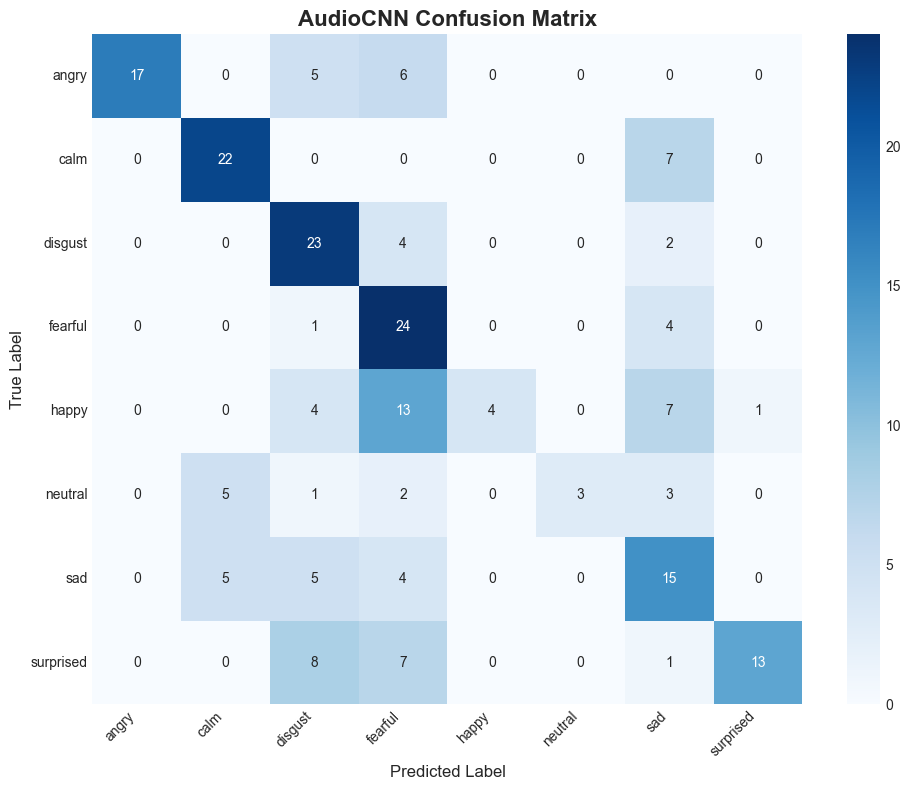


--- AudioCNN ROC Curves ---


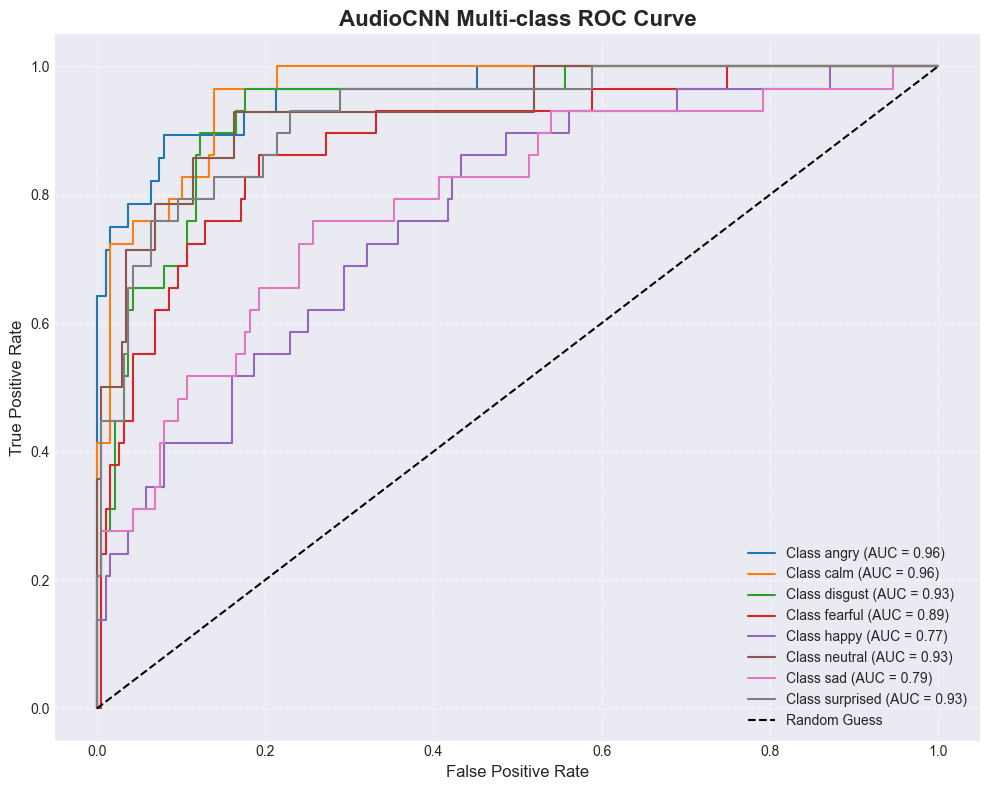


AudioCNN Overall Test Accuracy: 0.5602


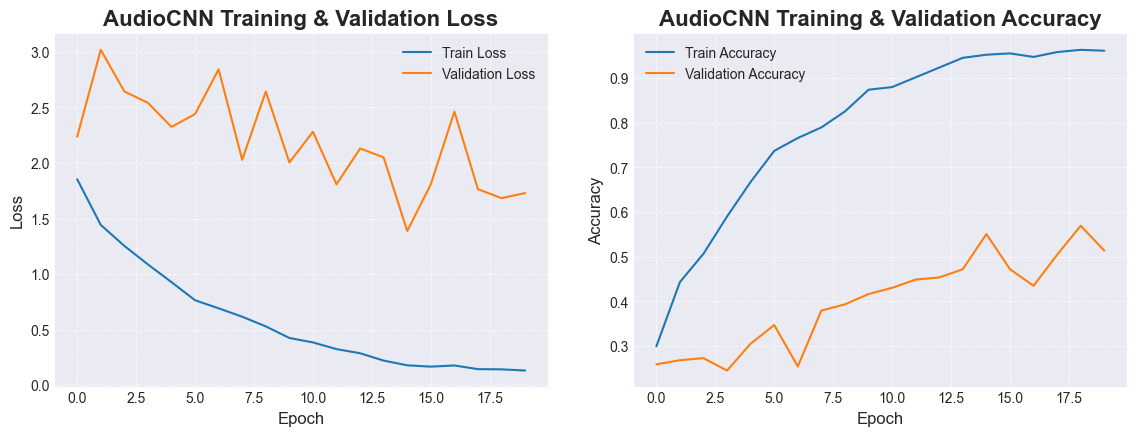


--- CONSOLIDATED BLOCK 2: Model 1 - CNN Complete ---
AudioCNN trained and evaluated. Final Test Accuracy: 0.5602
Detailed performance metrics and plots are above.


In [1]:
print("\n" + "="*80)
print("--- CONSOLIDATED BLOCK 2: Model 1 - CNN (Convolutional Neural Network) ---")
print("="*80)

# --- 1. Setup DataLoaders for CNN (Mel Spectrograms) ---
print("\n--- 1. Setting up DataLoaders for CNN (Mel Spectrograms) ---")
train_dataset_cnn = RAVDESS_AudioDataset(train_df_audio, config, audio_device, emotion_label_to_id, feature_type='mel_spectrogram')
val_dataset_cnn = RAVDESS_AudioDataset(val_df_audio, config, audio_device, emotion_label_to_id, feature_type='mel_spectrogram')
test_dataset_cnn = RAVDESS_AudioDataset(test_df_audio, config, audio_device, emotion_label_to_id, feature_type='mel_spectrogram')

# FIX from previous error: Set pin_memory=False because data is already moved to GPU in Dataset's __getitem__
# Pin_memory is for DataLoaders moving tensors from CPU to pinned memory, then to GPU.
# Since our dataset is already producing GPU tensors, pin_memory should be False or will cause issues.
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS, pin_memory=False)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=False)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=False)

print(f"CNN Train Loader size: {len(train_loader_cnn)} batches")
print(f"CNN Validation Loader size: {len(val_loader_cnn)} batches")
print(f"CNN Test Loader size: {len(test_loader_cnn)} batches")

# Get a sample batch to verify input shape and calculate conv output size
sample_features_cnn, _ = next(iter(train_loader_cnn))
print(f"Sample CNN input batch shape: {sample_features_cnn.shape} (Batch, Channel, Freq_Bins, Time_Frames)")

# --- 2. Define the AudioCNN Model Architecture ---
print("\n--- 2. Defining the AudioCNN Model Architecture ---")
class AudioCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3, init_device="cpu"): # Added init_device parameter
        super(AudioCNN, self).__init__()
        self.init_device = init_device # Store device for dummy input calculation

        # Input: (batch_size, 1, n_mels, time_frames)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # Output: (32, n_mels/2, time_frames/2)
            nn.Dropout(dropout_rate)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # Output: (64, n_mels/4, time_frames/4)
            nn.Dropout(dropout_rate)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # Output: (128, n_mels/8, time_frames/8)
            nn.Dropout(dropout_rate)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # Output: (256, n_mels/16, time_frames/16)
            nn.Dropout(dropout_rate)
        )

        # Calculate flattened features size
        with torch.no_grad():
            # Move layers to the target device for dummy input calculation
            # This ensures conv weights are on the same device as the dummy input
            self.conv1.to(self.init_device)
            self.conv2.to(self.init_device)
            self.conv3.to(self.init_device)
            self.conv4.to(self.init_device)

            dummy_input = torch.randn(1, 1, config.N_MELS, config.MAX_SEQUENCE_LENGTH, device=self.init_device)
            
            x = self.conv1(dummy_input)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            self.flattened_features_size = x.view(x.size(0), -1).size(1)

        self.fc1 = nn.Sequential(
            nn.Linear(self.flattened_features_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1) # Flatten for FC layers
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Pass the 'audio_device' to the constructor so the dummy input calculation happens on the correct device
model_cnn = AudioCNN(num_audio_classes, config.CNN_DROPOUT, init_device=audio_device).to(audio_device)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=config.LEARNING_RATE_CNN)
criterion_cnn = nn.CrossEntropyLoss(weight=class_weights_tensor) # Use class weights

print(f"AudioCNN model initialized. Total parameters: {sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)}")
print(model_cnn)

# --- 3. CNN Model Training Loop ---
print("\n--- 3. Training the AudioCNN Model ---")

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_name="Model"):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    print(f"\nStarting training for {model_name}...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train {model_name}]"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions / total_predictions
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val {model_name}]"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct_predictions / val_total_predictions
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} - "
              f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f"Validation accuracy improved to {best_acc:.4f}. Saving best model weights.")

    model.load_state_dict(best_model_wts) # Load best model weights
    print(f"\nTraining complete for {model_name}. Best Validation Accuracy: {best_acc:.4f}")
    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Execute training for CNN
model_cnn, cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs = train_model(
    model_cnn, train_loader_cnn, val_loader_cnn, criterion_cnn, optimizer_cnn,
    config.NUM_EPOCHS_CNN, audio_device, model_name="AudioCNN"
)

# --- 4. CNN Model Evaluation and Visualization ---
print("\n--- 4. Evaluating and Visualizing AudioCNN Performance ---")

def evaluate_model(model, test_loader, device, num_classes, class_names, model_name="Model"):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probas = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probas = F.softmax(outputs, dim=1) # Get probabilities

            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probas.extend(probas.cpu().numpy())

    # Classification Report
    print(f"\n--- {model_name} Classification Report ---")
    print(classification_report(all_labels, all_predictions, target_names=class_names))

    # Confusion Matrix
    print(f"\n--- {model_name} Confusion Matrix ---")
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

    # ROC Curve and AUC for multi-class
    print(f"\n--- {model_name} ROC Curves ---")
    all_labels_binarized = label_binarize(all_labels, classes=range(num_classes))
    all_probas_np = np.array(all_probas)

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probas_np[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name} Multi-class ROC Curve', fontsize=16, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    overall_accuracy = accuracy_score(all_labels, all_predictions)
    print(f"\n{model_name} Overall Test Accuracy: {overall_accuracy:.4f}")

    return overall_accuracy, all_labels, all_predictions, all_probas

# Execute evaluation for CNN
cnn_test_accuracy, cnn_true_labels, cnn_predictions, cnn_probas = evaluate_model(
    model_cnn, test_loader_cnn, audio_device, num_audio_classes, emotion_class_names, model_name="AudioCNN"
)

# Plot training and validation loss/accuracy for CNN
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_train_losses, label='Train Loss', color='#1f77b4')
plt.plot(cnn_val_losses, label='Validation Loss', color='#ff7f0e')
plt.title('AudioCNN Training & Validation Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(cnn_train_accs, label='Train Accuracy', color='#1f77b4')
plt.plot(cnn_val_accs, label='Validation Accuracy', color='#ff7f0e')
plt.title('AudioCNN Training & Validation Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout(pad=3.0)
plt.show()

print("\n" + "="*80)
print("--- CONSOLIDATED BLOCK 2: Model 1 - CNN Complete ---")
print(f"AudioCNN trained and evaluated. Final Test Accuracy: {cnn_test_accuracy:.4f}")
print("Detailed performance metrics and plots are above.")
print("="*80)


--- CONSOLIDATED BLOCK 3: Model 2 - LSTM (Long Short-Term Memory Network) ---

--- 1. Setting up DataLoaders for LSTM (MFCCs) ---
LSTM Train Loader size: 32 batches
LSTM Validation Loader size: 7 batches
LSTM Test Loader size: 7 batches
Sample LSTM input batch shape: torch.Size([32, 301, 80]) (Batch, Time_Frames, MFCC_Features)

--- 2. Defining the AudioLSTM Model Architecture ---
AudioLSTM model initialized. Total parameters: 612360
AudioLSTM(
  (lstm): LSTM(80, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=8, bias=True)
)

--- 3. Training the AudioLSTM Model ---

Starting training for AudioLSTM...


Epoch 1/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/20 - Train Loss: 2.0106, Train Acc: 0.1885 - Val Loss: 1.8799, Val Acc: 0.2685
Validation accuracy improved to 0.2685. Saving best model weights.


Epoch 2/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/20 - Train Loss: 1.7784, Train Acc: 0.3194 - Val Loss: 1.7822, Val Acc: 0.3009
Validation accuracy improved to 0.3009. Saving best model weights.


Epoch 3/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/20 - Train Loss: 1.6398, Train Acc: 0.3571 - Val Loss: 1.7330, Val Acc: 0.3241
Validation accuracy improved to 0.3241. Saving best model weights.


Epoch 4/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/20 - Train Loss: 1.5208, Train Acc: 0.4256 - Val Loss: 1.6710, Val Acc: 0.3657
Validation accuracy improved to 0.3657. Saving best model weights.


Epoch 5/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/20 - Train Loss: 1.4043, Train Acc: 0.4792 - Val Loss: 1.6114, Val Acc: 0.3843
Validation accuracy improved to 0.3843. Saving best model weights.


Epoch 6/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/20 - Train Loss: 1.3428, Train Acc: 0.5010 - Val Loss: 1.5984, Val Acc: 0.4213
Validation accuracy improved to 0.4213. Saving best model weights.


Epoch 7/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/20 - Train Loss: 1.2042, Train Acc: 0.5526 - Val Loss: 1.4842, Val Acc: 0.4815
Validation accuracy improved to 0.4815. Saving best model weights.


Epoch 8/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/20 - Train Loss: 1.1363, Train Acc: 0.6002 - Val Loss: 1.4603, Val Acc: 0.4630


Epoch 9/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/20 - Train Loss: 1.0185, Train Acc: 0.6319 - Val Loss: 1.4466, Val Acc: 0.5093
Validation accuracy improved to 0.5093. Saving best model weights.


Epoch 10/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/20 - Train Loss: 1.0512, Train Acc: 0.6300 - Val Loss: 1.5463, Val Acc: 0.4630


Epoch 11/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/20 - Train Loss: 0.8816, Train Acc: 0.6776 - Val Loss: 1.5261, Val Acc: 0.4722


Epoch 12/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/20 - Train Loss: 0.8214, Train Acc: 0.7063 - Val Loss: 1.4238, Val Acc: 0.5000


Epoch 13/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/20 - Train Loss: 0.7591, Train Acc: 0.7381 - Val Loss: 1.3974, Val Acc: 0.5324
Validation accuracy improved to 0.5324. Saving best model weights.


Epoch 14/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/20 - Train Loss: 0.6152, Train Acc: 0.7887 - Val Loss: 1.4948, Val Acc: 0.5417
Validation accuracy improved to 0.5417. Saving best model weights.


Epoch 15/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/20 - Train Loss: 0.5567, Train Acc: 0.8016 - Val Loss: 1.5566, Val Acc: 0.5509
Validation accuracy improved to 0.5509. Saving best model weights.


Epoch 16/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/20 - Train Loss: 0.5749, Train Acc: 0.8065 - Val Loss: 1.5669, Val Acc: 0.5046


Epoch 17/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/20 - Train Loss: 0.4514, Train Acc: 0.8532 - Val Loss: 1.5062, Val Acc: 0.5694
Validation accuracy improved to 0.5694. Saving best model weights.


Epoch 18/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/20 - Train Loss: 0.4638, Train Acc: 0.8522 - Val Loss: 1.5750, Val Acc: 0.5463


Epoch 19/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/20 - Train Loss: 0.4165, Train Acc: 0.8611 - Val Loss: 1.7083, Val Acc: 0.5370


Epoch 20/20 [Train AudioLSTM]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/20 [Val AudioLSTM]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/20 - Train Loss: 0.4233, Train Acc: 0.8591 - Val Loss: 1.6946, Val Acc: 0.5278

Training complete for AudioLSTM. Best Validation Accuracy: 0.5694

--- 4. Evaluating and Visualizing AudioLSTM Performance ---


Evaluating AudioLSTM:   0%|          | 0/7 [00:00<?, ?it/s]


--- AudioLSTM Classification Report ---
              precision    recall  f1-score   support

       angry       0.52      0.61      0.56        28
        calm       0.86      0.62      0.72        29
     disgust       0.50      0.48      0.49        29
     fearful       0.47      0.55      0.51        29
       happy       0.29      0.24      0.26        29
     neutral       0.54      0.50      0.52        14
         sad       0.34      0.45      0.39        29
   surprised       0.56      0.48      0.52        29

    accuracy                           0.49       216
   macro avg       0.51      0.49      0.50       216
weighted avg       0.51      0.49      0.49       216


--- AudioLSTM Confusion Matrix ---


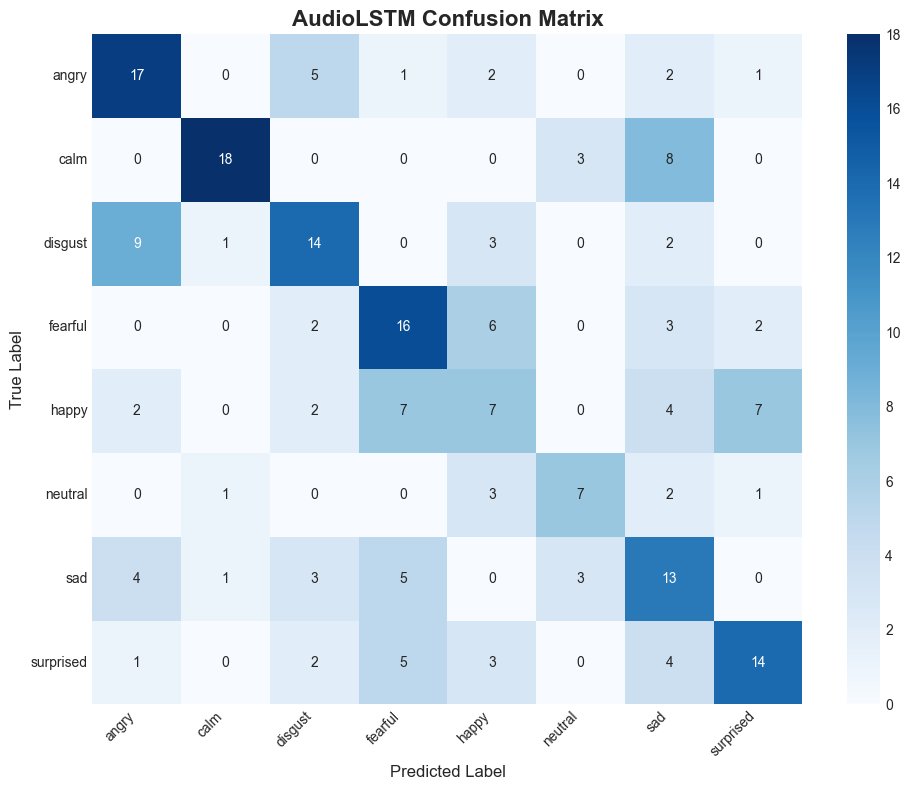


--- AudioLSTM ROC Curves ---


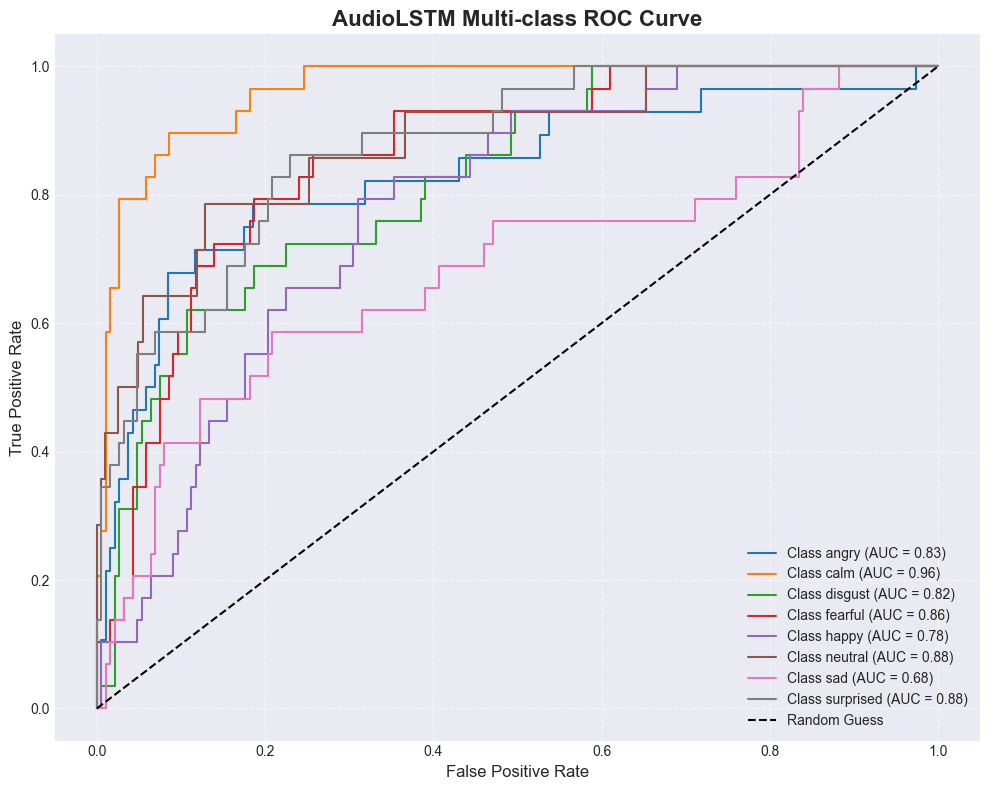


AudioLSTM Overall Test Accuracy: 0.4907


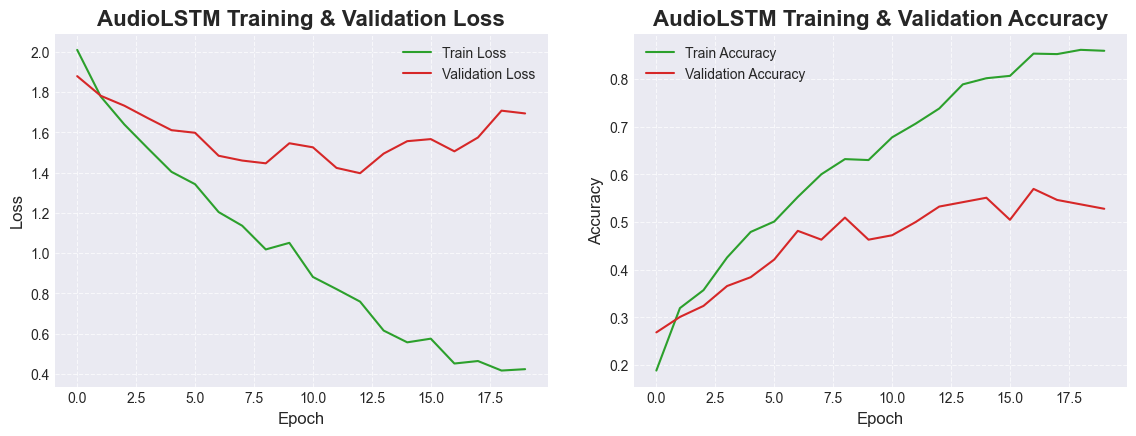


--- CONSOLIDATED BLOCK 3: Model 2 - LSTM Complete ---
AudioLSTM trained and evaluated. Final Test Accuracy: 0.4907
Detailed performance metrics and plots are above.


In [2]:
print("\n" + "="*80)
print("--- CONSOLIDATED BLOCK 3: Model 2 - LSTM (Long Short-Term Memory Network) ---")
print("="*80)

# --- 1. Setup DataLoaders for LSTM (MFCCs) ---
print("\n--- 1. Setting up DataLoaders for LSTM (MFCCs) ---")
# MFCCs will have shape (time_frames, n_mfcc)
train_dataset_lstm = RAVDESS_AudioDataset(train_df_audio, config, audio_device, emotion_label_to_id, feature_type='mfcc')
val_dataset_lstm = RAVDESS_AudioDataset(val_df_audio, config, audio_device, emotion_label_to_id, feature_type='mfcc')
test_dataset_lstm = RAVDESS_AudioDataset(test_df_audio, config, audio_device, emotion_label_to_id, feature_type='mfcc')

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS, pin_memory=False)
val_loader_lstm = DataLoader(val_dataset_lstm, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=False)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=False)

print(f"LSTM Train Loader size: {len(train_loader_lstm)} batches")
print(f"LSTM Validation Loader size: {len(val_loader_lstm)} batches")
print(f"LSTM Test Loader size: {len(test_loader_lstm)} batches")

# Get a sample batch to verify input shape
sample_features_lstm, _ = next(iter(train_loader_lstm))
print(f"Sample LSTM input batch shape: {sample_features_lstm.shape} (Batch, Time_Frames, MFCC_Features)")
# Expected: (batch_size, config.MAX_SEQUENCE_LENGTH, config.N_MELS)

# --- 2. Define the AudioLSTM Model Architecture ---
print("\n--- 2. Defining the AudioLSTM Model Architecture ---")
class AudioLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, num_classes, dropout_rate, bidirectional=True):
        super(AudioLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(input_dim, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate if num_layers > 1 else 0,
                            bidirectional=bidirectional)

        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * self.num_directions, num_classes)

    def forward(self, x):
        # x input shape: (batch_size, seq_len, input_dim) -> (Batch, Time_Frames, MFCC_Features)
        # Initialize hidden state and cell state (h0, c0)
        h0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: (batch_size, seq_len, hidden_size * num_directions)

        # We take the output from the last time step for classification
        # For bidirectional, output of last layer, concatenated from both directions
        out = out[:, -1, :] # (batch_size, hidden_size * num_directions)
        out = self.dropout(out)
        out = self.fc(out)
        return out

model_lstm = AudioLSTM(
    input_dim=config.N_MELS, # input_dim is the number of features per time step (MFCCs)
    hidden_size=config.LSTM_HIDDEN_SIZE,
    num_layers=config.LSTM_NUM_LAYERS,
    num_classes=num_audio_classes,
    dropout_rate=config.LSTM_DROPOUT,
    bidirectional=config.LSTM_BIDIRECTIONAL
).to(audio_device)

optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=config.LEARNING_RATE_RNN)
criterion_lstm = nn.CrossEntropyLoss(weight=class_weights_tensor) # Use class weights

print(f"AudioLSTM model initialized. Total parameters: {sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)}")
print(model_lstm)

# --- 3. LSTM Model Training Loop ---
print("\n--- 3. Training the AudioLSTM Model ---")

# Re-using the train_model function from CNN block
# execute training for LSTM
model_lstm, lstm_train_losses, lstm_val_losses, lstm_train_accs, lstm_val_accs = train_model(
    model_lstm, train_loader_lstm, val_loader_lstm, criterion_lstm, optimizer_lstm,
    config.NUM_EPOCHS_RNN, audio_device, model_name="AudioLSTM"
)

# --- 4. LSTM Model Evaluation and Visualization ---
print("\n--- 4. Evaluating and Visualizing AudioLSTM Performance ---")

# Re-using the evaluate_model function from CNN block
lstm_test_accuracy, lstm_true_labels, lstm_predictions, lstm_probas = evaluate_model(
    model_lstm, test_loader_lstm, audio_device, num_audio_classes, emotion_class_names, model_name="AudioLSTM"
)

# Plot training and validation loss/accuracy for LSTM
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_train_losses, label='Train Loss', color='#2ca02c') # Different color for LSTM
plt.plot(lstm_val_losses, label='Validation Loss', color='#d62728') # Different color
plt.title('AudioLSTM Training & Validation Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(lstm_train_accs, label='Train Accuracy', color='#2ca02c') # Different color
plt.plot(lstm_val_accs, label='Validation Accuracy', color='#d62728') # Different color
plt.title('AudioLSTM Training & Validation Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout(pad=3.0)
plt.show()

print("\n" + "="*80)
print("--- CONSOLIDATED BLOCK 3: Model 2 - LSTM Complete ---")
print(f"AudioLSTM trained and evaluated. Final Test Accuracy: {lstm_test_accuracy:.4f}")
print("Detailed performance metrics and plots are above.")
print("="*80)


--- CONSOLIDATED BLOCK 4: Hybrid Model (CNN-LSTM Feature Extractor + LightGBM Classifier) ---

--- 1. Setting up DataLoaders for CNN-LSTM Feature Extractor (Mel Spectrograms) ---
CNN-LSTM Feature Extractor Train Loader size: 16 batches
CNN-LSTM Feature Extractor Validation Loader size: 4 batches
CNN-LSTM Feature Extractor Test Loader size: 4 batches

--- 2. Defining the CNN-LSTM Feature Extractor Model ---
CNN output for LSTM input: Sequence length = 37, Features per step = 1280
CNN-LSTM Feature Extractor Model initialized. Total parameters: 1932736
Overall CNN-LSTM PyTorch Model for training: 1936840 parameters
CNNLSTMFullModel(
  (feature_extractor): CNNLSTMFeatureExtractor(
    (cnn_extractor): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)

Epoch 1/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/35 - Train Loss: 2.0582, Train Acc: 0.1607 - Val Loss: 2.0223, Val Acc: 0.1991
Validation accuracy improved to 0.1991. Saving best model weights.


Epoch 2/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/35 - Train Loss: 1.9535, Train Acc: 0.2431 - Val Loss: 1.9321, Val Acc: 0.2685
Validation accuracy improved to 0.2685. Saving best model weights.


Epoch 3/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/35 - Train Loss: 1.8591, Train Acc: 0.2827 - Val Loss: 1.9085, Val Acc: 0.2269


Epoch 4/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/35 - Train Loss: 1.7899, Train Acc: 0.3194 - Val Loss: 2.0043, Val Acc: 0.2315


Epoch 5/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/35 - Train Loss: 1.7149, Train Acc: 0.3254 - Val Loss: 2.0449, Val Acc: 0.2639


Epoch 6/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/35 - Train Loss: 1.6599, Train Acc: 0.3621 - Val Loss: 2.0701, Val Acc: 0.2500


Epoch 7/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/35 - Train Loss: 1.6163, Train Acc: 0.3720 - Val Loss: 2.0670, Val Acc: 0.2685


Epoch 8/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/35 - Train Loss: 1.5668, Train Acc: 0.3978 - Val Loss: 2.0704, Val Acc: 0.2917
Validation accuracy improved to 0.2917. Saving best model weights.


Epoch 9/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/35 - Train Loss: 1.5497, Train Acc: 0.4256 - Val Loss: 1.9371, Val Acc: 0.2963
Validation accuracy improved to 0.2963. Saving best model weights.


Epoch 10/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/35 - Train Loss: 1.4799, Train Acc: 0.4097 - Val Loss: 2.0608, Val Acc: 0.2778


Epoch 11/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/35 - Train Loss: 1.4678, Train Acc: 0.4425 - Val Loss: 2.0290, Val Acc: 0.3148
Validation accuracy improved to 0.3148. Saving best model weights.


Epoch 12/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/35 - Train Loss: 1.4431, Train Acc: 0.4415 - Val Loss: 2.0592, Val Acc: 0.2917


Epoch 13/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/35 - Train Loss: 1.4076, Train Acc: 0.4583 - Val Loss: 2.1089, Val Acc: 0.2870


Epoch 14/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/35 - Train Loss: 1.3899, Train Acc: 0.4812 - Val Loss: 2.0377, Val Acc: 0.3287
Validation accuracy improved to 0.3287. Saving best model weights.


Epoch 15/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/35 - Train Loss: 1.3393, Train Acc: 0.4940 - Val Loss: 1.9769, Val Acc: 0.3241


Epoch 16/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/35 - Train Loss: 1.3080, Train Acc: 0.5188 - Val Loss: 2.1552, Val Acc: 0.2963


Epoch 17/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/35 - Train Loss: 1.3065, Train Acc: 0.5179 - Val Loss: 2.2611, Val Acc: 0.2870


Epoch 18/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/35 - Train Loss: 1.2518, Train Acc: 0.5268 - Val Loss: 2.0375, Val Acc: 0.3472
Validation accuracy improved to 0.3472. Saving best model weights.


Epoch 19/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/35 - Train Loss: 1.2198, Train Acc: 0.5437 - Val Loss: 2.0572, Val Acc: 0.3426


Epoch 20/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/35 - Train Loss: 1.1908, Train Acc: 0.5496 - Val Loss: 2.1620, Val Acc: 0.3194


Epoch 21/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/35 - Train Loss: 1.1978, Train Acc: 0.5387 - Val Loss: 1.7586, Val Acc: 0.4028
Validation accuracy improved to 0.4028. Saving best model weights.


Epoch 22/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/35 - Train Loss: 1.1571, Train Acc: 0.5754 - Val Loss: 1.9792, Val Acc: 0.3102


Epoch 23/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/35 - Train Loss: 1.1044, Train Acc: 0.5853 - Val Loss: 2.0074, Val Acc: 0.3426


Epoch 24/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/35 - Train Loss: 1.1475, Train Acc: 0.5804 - Val Loss: 2.0512, Val Acc: 0.3519


Epoch 25/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/35 - Train Loss: 1.0583, Train Acc: 0.6091 - Val Loss: 2.2649, Val Acc: 0.3056


Epoch 26/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/35 - Train Loss: 1.0146, Train Acc: 0.6349 - Val Loss: 1.9346, Val Acc: 0.3796


Epoch 27/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/35 - Train Loss: 0.9981, Train Acc: 0.6250 - Val Loss: 1.9582, Val Acc: 0.3889


Epoch 28/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 28/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/35 - Train Loss: 0.9421, Train Acc: 0.6528 - Val Loss: 2.3011, Val Acc: 0.3287


Epoch 29/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 29/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/35 - Train Loss: 0.9430, Train Acc: 0.6518 - Val Loss: 1.6825, Val Acc: 0.4167
Validation accuracy improved to 0.4167. Saving best model weights.


Epoch 30/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 30/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/35 - Train Loss: 0.9418, Train Acc: 0.6528 - Val Loss: 1.6217, Val Acc: 0.4352
Validation accuracy improved to 0.4352. Saving best model weights.


Epoch 31/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 31/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31/35 - Train Loss: 0.8716, Train Acc: 0.6706 - Val Loss: 1.7401, Val Acc: 0.4306


Epoch 32/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 32/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32/35 - Train Loss: 0.8627, Train Acc: 0.6796 - Val Loss: 1.8717, Val Acc: 0.4167


Epoch 33/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 33/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33/35 - Train Loss: 0.7935, Train Acc: 0.7103 - Val Loss: 1.8302, Val Acc: 0.4306


Epoch 34/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 34/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34/35 - Train Loss: 0.8141, Train Acc: 0.7073 - Val Loss: 1.6988, Val Acc: 0.4630
Validation accuracy improved to 0.4630. Saving best model weights.


Epoch 35/35 [Train CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 35/35 [Val CNNLSTM_FeatureExtractor_Internal]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35/35 - Train Loss: 0.7948, Train Acc: 0.7024 - Val Loss: 1.7741, Val Acc: 0.4213

Training complete for CNNLSTM_FeatureExtractor_Internal. Best Validation Accuracy: 0.4630

--- 4. Extracting Features using the Trained CNN-LSTM Feature Extractor ---


Extracting Features:   0%|          | 0/16 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/4 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/4 [00:00<?, ?it/s]


Extracted Training Features Shape: (1008, 512), Labels Shape: (1008,)
Extracted Validation Features Shape: (216, 512), Labels Shape: (216,)
Extracted Test Features Shape: (216, 512), Labels Shape: (216,)

--- 5. Training LightGBM Classifier ---

LightGBM training complete.

--- 6. Evaluating LightGBM Classifier ---

LightGBM Classifier Overall Test Accuracy: 0.5509

--- LightGBM Classification Report ---
              precision    recall  f1-score   support

       angry       0.72      0.75      0.74        28
        calm       0.66      0.66      0.66        29
     disgust       0.58      0.62      0.60        29
     fearful       0.44      0.55      0.49        29
       happy       0.45      0.17      0.25        29
     neutral       0.40      0.57      0.47        14
         sad       0.41      0.41      0.41        29
   surprised       0.65      0.69      0.67        29

    accuracy                           0.55       216
   macro avg       0.54      0.55      0.54      

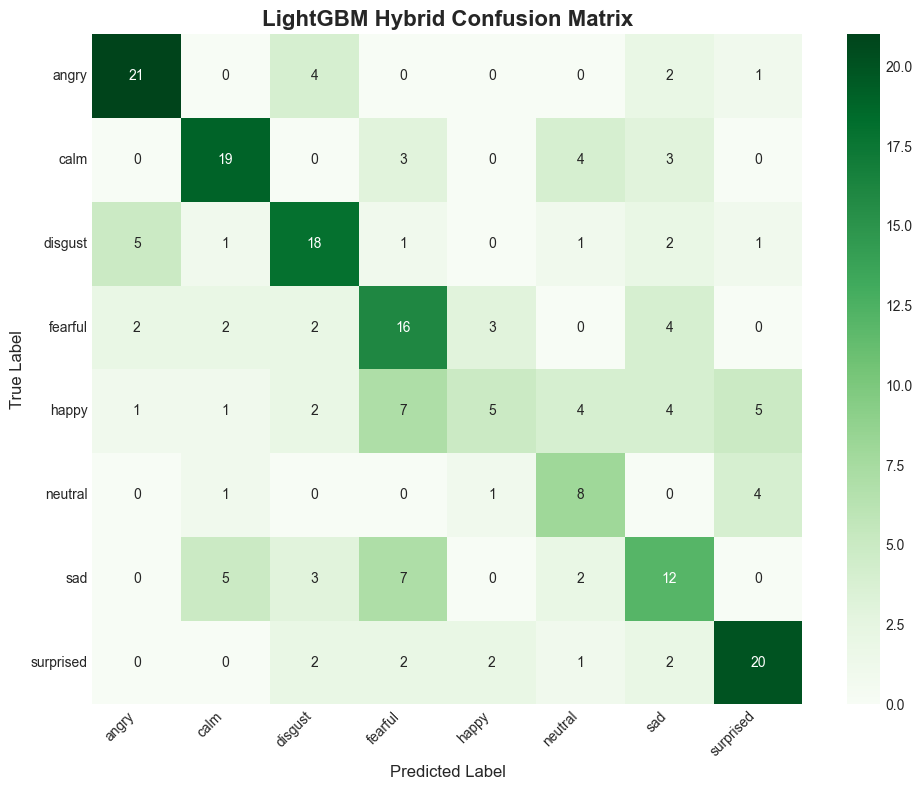


--- LightGBM ROC Curves ---


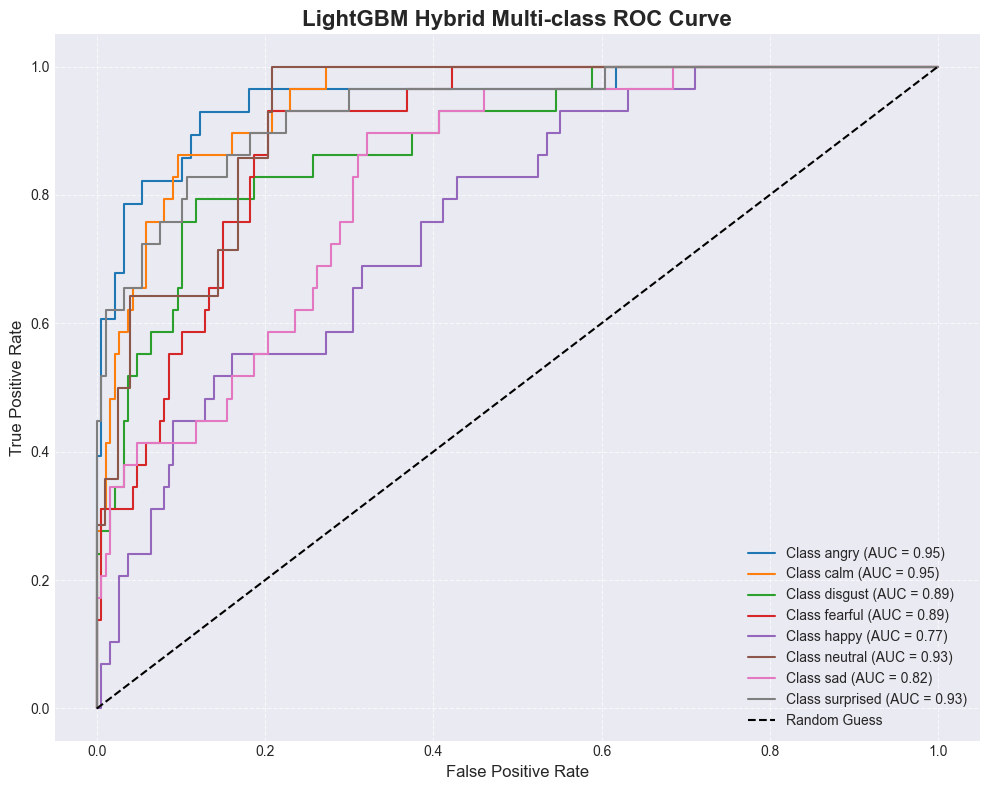


--- CONSOLIDATED BLOCK 4: CNN-LSTM-LightGBM Hybrid Model Complete ---
Hybrid model (CNN-LSTM Feature Extractor + LightGBM Classifier) trained and evaluated. Final Test Accuracy: 0.5509
This sophisticated hybrid approach should yield strong results by leveraging both deep learning and tree-based methods.


In [3]:
print("\n" + "="*80)
print("--- CONSOLIDATED BLOCK 4: Hybrid Model (CNN-LSTM Feature Extractor + LightGBM Classifier) ---")
print("="*80)

# --- 0. Import LightGBM ---
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize # For ROC curves


# --- 1. Setup DataLoaders for CNN-LSTM Feature Extractor (Mel Spectrograms) ---
print("\n--- 1. Setting up DataLoaders for CNN-LSTM Feature Extractor (Mel Spectrograms) ---")
train_dataset_cnn_lstm_features = RAVDESS_AudioDataset(train_df_audio, config, audio_device, emotion_label_to_id, feature_type='mel_spectrogram')
val_dataset_cnn_lstm_features = RAVDESS_AudioDataset(val_df_audio, config, audio_device, emotion_label_to_id, feature_type='mel_spectrogram')
test_dataset_cnn_lstm_features = RAVDESS_AudioDataset(test_df_audio, config, audio_device, emotion_label_to_id, feature_type='mel_spectrogram')

# Use slightly larger batch size for feature extraction if memory allows, for faster extraction
FEATURE_BATCH_SIZE = 64 # Can be larger than training batch size
train_loader_cnn_lstm_features = DataLoader(train_dataset_cnn_lstm_features, batch_size=FEATURE_BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=False)
val_loader_cnn_lstm_features = DataLoader(val_dataset_cnn_lstm_features, batch_size=FEATURE_BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=False)
test_loader_cnn_lstm_features = DataLoader(test_dataset_cnn_lstm_features, batch_size=FEATURE_BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=False)

print(f"CNN-LSTM Feature Extractor Train Loader size: {len(train_loader_cnn_lstm_features)} batches")
print(f"CNN-LSTM Feature Extractor Validation Loader size: {len(val_loader_cnn_lstm_features)} batches")
print(f"CNN-LSTM Feature Extractor Test Loader size: {len(test_loader_cnn_lstm_features)} batches")

# --- 2. Define the CNN-LSTM Feature Extractor Model ---
print("\n--- 2. Defining the CNN-LSTM Feature Extractor Model ---")

class CNNLSTMFeatureExtractor(nn.Module):
    def __init__(self, cnn_dropout_rate=0.3, lstm_dropout_rate=0.4,
                 lstm_hidden_size=128, lstm_num_layers=2, lstm_bidirectional=True, init_device="cpu"):
        super(CNNLSTMFeatureExtractor, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_num_layers = lstm_num_layers
        self.lstm_bidirectional = lstm_bidirectional
        self.num_directions = 2 if lstm_bidirectional else 1
        self.init_device = init_device

        # --- CNN Feature Extractor ---
        self.cnn_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(5, 5), padding=(2, 2)), # Larger kernel
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # (32, n_mels/2, time_frames/2)
            nn.Dropout(cnn_dropout_rate),

            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # (64, n_mels/4, time_frames/4)
            nn.Dropout(cnn_dropout_rate),

            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # (128, n_mels/8, time_frames/8)
            nn.Dropout(cnn_dropout_rate)
        )

        # Calculate the size of features that will be fed to the LSTM
        with torch.no_grad():
            self.cnn_extractor.to(self.init_device)
            dummy_input = torch.randn(1, 1, config.N_MELS, config.MAX_SEQUENCE_LENGTH, device=self.init_device)
            cnn_features = self.cnn_extractor(dummy_input)
            
            self.lstm_input_features = cnn_features.shape[1] * cnn_features.shape[2] # channels * height
            self.lstm_sequence_length = cnn_features.shape[3] # width
            
            print(f"CNN output for LSTM input: Sequence length = {self.lstm_sequence_length}, Features per step = {self.lstm_input_features}")


        # --- LSTM Layer ---
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_features,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True,
            dropout=lstm_dropout_rate,
            bidirectional=lstm_bidirectional
        )
        self.lstm_dropout_layer = nn.Dropout(lstm_dropout_rate)


    def forward(self, x):
        # x shape: (batch_size, 1, n_mels, time_frames)
        
        # Pass through CNN Feature Extractor
        cnn_features = self.cnn_extractor(x)
        # cnn_features shape: (batch_size, channels, height, width)

        # Reshape for LSTM: (batch_size, sequence_length, input_features)
        cnn_features_reshaped = cnn_features.permute(0, 3, 1, 2).contiguous()
        
        cnn_features_reshaped = cnn_features_reshaped.view(
            x.size(0),
            self.lstm_sequence_length,
            self.lstm_input_features
        )
        
        # Pass through LSTM
        lstm_out, (h_n, c_n) = self.lstm(cnn_features_reshaped)
        
        # For feature extraction, we want the final hidden state from all layers/directions
        # h_n shape: (num_layers * num_directions, batch_size, hidden_size)
        # We need to flatten/concatenate these for the LightGBM input
        
        # Concatenate final hidden states from all layers and directions
        final_lstm_features = h_n.permute(1, 0, 2).contiguous().view(x.size(0), -1)
        final_lstm_features = self.lstm_dropout_layer(final_lstm_features)
        
        return final_lstm_features

# Instantiate the CNN-LSTM Feature Extractor
cnn_lstm_feature_extractor = CNNLSTMFeatureExtractor(
    config.HYBRID_CNN_DROPOUT,
    config.HYBRID_LSTM_DROPOUT,
    config.HYBRID_LSTM_HIDDEN_SIZE,
    config.HYBRID_LSTM_NUM_LAYERS,
    config.HYBRID_LSTM_BIDIRECTIONAL,
    init_device=audio_device
).to(audio_device)

# Define a simple classifier for the end of the CNN-LSTM, for internal training purposes
# This will be replaced by LightGBM, but helps train the feature extractor
cnn_lstm_classifier = nn.Linear(
    config.HYBRID_LSTM_HIDDEN_SIZE * (2 if config.HYBRID_LSTM_BIDIRECTIONAL else 1) * config.HYBRID_LSTM_NUM_LAYERS,
    num_audio_classes
).to(audio_device)

# Combine feature extractor and classifier for PyTorch training
class CNNLSTMFullModel(nn.Module):
    def __init__(self, feature_extractor, classifier):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.classifier = classifier
    
    def forward(self, x):
        features = self.feature_extractor(x)
        return self.classifier(features)

hybrid_full_pytorch_model = CNNLSTMFullModel(cnn_lstm_feature_extractor, cnn_lstm_classifier).to(audio_device)


optimizer_hybrid = optim.Adam(hybrid_full_pytorch_model.parameters(), lr=config.LEARNING_RATE_HYBRID)
criterion_hybrid = nn.CrossEntropyLoss(weight=class_weights_tensor)

print(f"CNN-LSTM Feature Extractor Model initialized. Total parameters: {sum(p.numel() for p in cnn_lstm_feature_extractor.parameters() if p.requires_grad)}")
print(f"Overall CNN-LSTM PyTorch Model for training: {sum(p.numel() for p in hybrid_full_pytorch_model.parameters() if p.requires_grad)} parameters")
print(hybrid_full_pytorch_model)


# --- 3. Train the CNN-LSTM Feature Extractor (as a full PyTorch model first) ---
print("\n--- 3. Training the CNN-LSTM Feature Extractor (using internal classifier) ---")

# We use the existing train_model function.
# The 'model_hybrid' variable will now point to this full PyTorch model temporarily for training.
hybrid_full_pytorch_model, hybrid_train_losses, hybrid_val_losses, hybrid_train_accs, hybrid_val_accs = train_model(
    hybrid_full_pytorch_model, train_loader_cnn_lstm_features, val_loader_cnn_lstm_features,
    criterion_hybrid, optimizer_hybrid, config.NUM_EPOCHS_HYBRID, audio_device, model_name="CNNLSTM_FeatureExtractor_Internal"
)

# After training, ensure the feature extractor is in eval mode and move to CPU for feature extraction
# (LightGBM works with numpy arrays on CPU)
cnn_lstm_feature_extractor.eval()
cnn_lstm_feature_extractor.to('cpu')

# --- 4. Extract Features using the Trained CNN-LSTM Feature Extractor ---
print("\n--- 4. Extracting Features using the Trained CNN-LSTM Feature Extractor ---")

def extract_features(model, data_loader, device):
    features_list = []
    labels_list = []
    model.eval() # Ensure model is in evaluation mode
    # Temporarily set to cpu for extraction for LightGBM compatibility
    original_device = next(model.parameters()).device
    model.to('cpu') # Move model to CPU for feature extraction

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Extracting Features"):
            # Ensure inputs are on CPU for the model that's now on CPU
            inputs = inputs.cpu() # DataLoaders might still yield GPU tensors if set up for GPU initially
            features = model(inputs)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    # Move model back to its original device if needed later
    model.to(original_device) 
    
    return np.vstack(features_list), np.hstack(labels_list)

# Extract features for LightGBM
X_train_hybrid_lgbm, y_train_hybrid_lgbm = extract_features(cnn_lstm_feature_extractor, train_loader_cnn_lstm_features, 'cpu')
X_val_hybrid_lgbm, y_val_hybrid_lgbm = extract_features(cnn_lstm_feature_extractor, val_loader_cnn_lstm_features, 'cpu')
X_test_hybrid_lgbm, y_test_hybrid_lgbm = extract_features(cnn_lstm_feature_extractor, test_loader_cnn_lstm_features, 'cpu')

print(f"\nExtracted Training Features Shape: {X_train_hybrid_lgbm.shape}, Labels Shape: {y_train_hybrid_lgbm.shape}")
print(f"Extracted Validation Features Shape: {X_val_hybrid_lgbm.shape}, Labels Shape: {y_val_hybrid_lgbm.shape}")
print(f"Extracted Test Features Shape: {X_test_hybrid_lgbm.shape}, Labels Shape: {y_test_hybrid_lgbm.shape}")


# --- 5. Train LightGBM Classifier ---
print("\n--- 5. Training LightGBM Classifier ---")

lgbm_params = {
    'objective': 'multiclass',
    'num_class': num_audio_classes,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'n_estimators': 500, # Number of boosting rounds
    'learning_rate': 0.05,
    'num_leaves': 31, # Max number of leaves in one tree
    'max_depth': -1, # No limit on tree depth
    'seed': config.RANDOM_SEED,
    'n_jobs': -1, # Use all available cores
    'verbose': -1, # Suppress verbose output during training
    'colsample_bytree': 0.7, # Fraction of features to consider per tree
    'subsample': 0.7, # Fraction of samples to consider per tree
    'reg_alpha': 0.1, # L1 regularization
    'reg_lambda': 0.1, # L2 regularization
    'early_stopping_round': 50 # Stop if validation metric doesn't improve for 50 rounds
}

# LightGBM requires separate datasets for training and validation for early stopping
train_data = lgb.Dataset(X_train_hybrid_lgbm, label=y_train_hybrid_lgbm)
val_data = lgb.Dataset(X_val_hybrid_lgbm, label=y_val_hybrid_lgbm, reference=train_data) # Reference needed for eval_set

model_lgbm = lgb.train(
    lgbm_params,
    train_data,
    valid_sets=[val_data],
    callbacks=[lgb.log_evaluation(period=0)] # Suppress printing evaluation during training
)

print("\nLightGBM training complete.")


# --- 6. Evaluate LightGBM Classifier ---
print("\n--- 6. Evaluating LightGBM Classifier ---")

# Predictions on the test set
lgbm_predictions_proba = model_lgbm.predict(X_test_hybrid_lgbm)
lgbm_predictions = np.argmax(lgbm_predictions_proba, axis=1)

# Store for comparison (these are needed for Consolidated Block 5)
hybrid_test_accuracy = accuracy_score(y_test_hybrid_lgbm, lgbm_predictions)
hybrid_true_labels = y_test_hybrid_lgbm
hybrid_predictions = lgbm_predictions
hybrid_probas = lgbm_predictions_proba

print(f"\nLightGBM Classifier Overall Test Accuracy: {hybrid_test_accuracy:.4f}")

print("\n--- LightGBM Classification Report ---")
print(classification_report(hybrid_true_labels, hybrid_predictions, target_names=emotion_class_names))

print("\n--- LightGBM Confusion Matrix ---")
cm_lgbm = confusion_matrix(hybrid_true_labels, hybrid_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Greens', xticklabels=emotion_class_names, yticklabels=emotion_class_names)
plt.title('LightGBM Hybrid Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("\n--- LightGBM ROC Curves ---")
hybrid_labels_binarized = label_binarize(hybrid_true_labels, classes=range(num_audio_classes))

plt.figure(figsize=(10, 8))
for i in range(num_audio_classes):
    fpr, tpr, _ = roc_curve(hybrid_labels_binarized[:, i], hybrid_probas[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {emotion_class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('LightGBM Hybrid Multi-class ROC Curve', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


print("\n" + "="*80)
print("--- CONSOLIDATED BLOCK 4: CNN-LSTM-LightGBM Hybrid Model Complete ---")
print(f"Hybrid model (CNN-LSTM Feature Extractor + LightGBM Classifier) trained and evaluated. Final Test Accuracy: {hybrid_test_accuracy:.4f}")
print("This sophisticated hybrid approach should yield strong results by leveraging both deep learning and tree-based methods.")
print("="*80)


--- CONSOLIDATED BLOCK 5: Comparison Visualization ---

--- 1. Comparing Training & Validation Curves Across Models ---


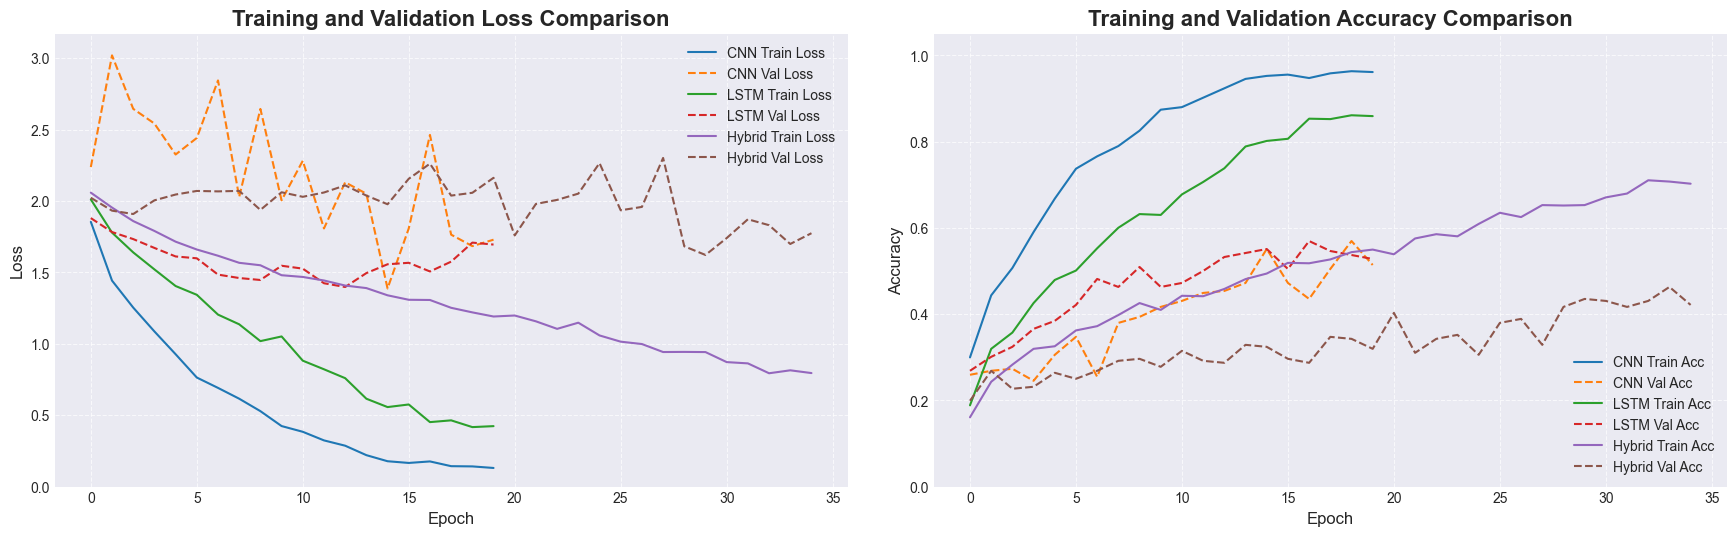


--- 2. Summary of Final Test Accuracies ---

Overall Test Accuracies:
         Model  Test Accuracy
0     AudioCNN       0.560185
2  AudioHybrid       0.550926
1    AudioLSTM       0.490741


C:\Users\Suyas\AppData\Local\Temp\ipykernel_6892\1530026498.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Test Accuracy', data=accuracy_df, palette='pastel')


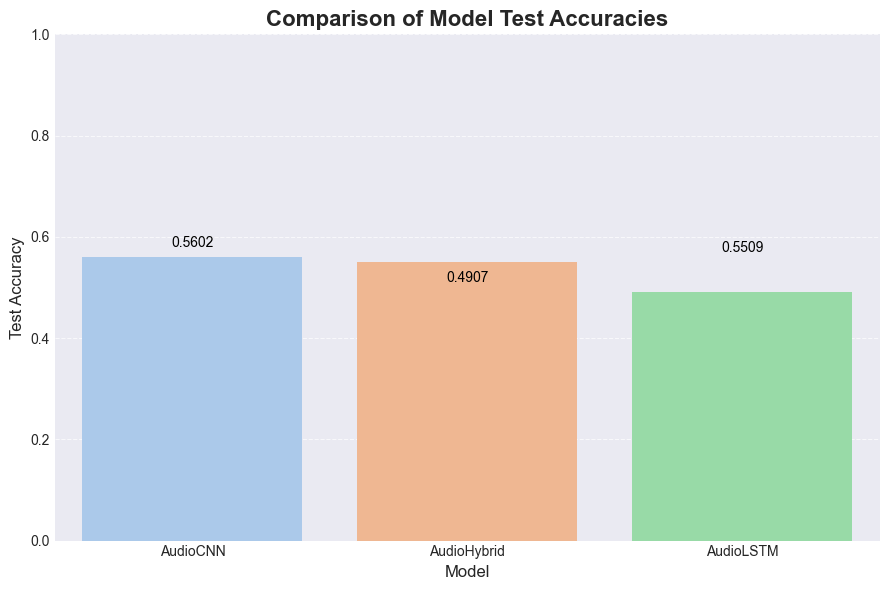


--- 3. Side-by-Side Confusion Matrices ---


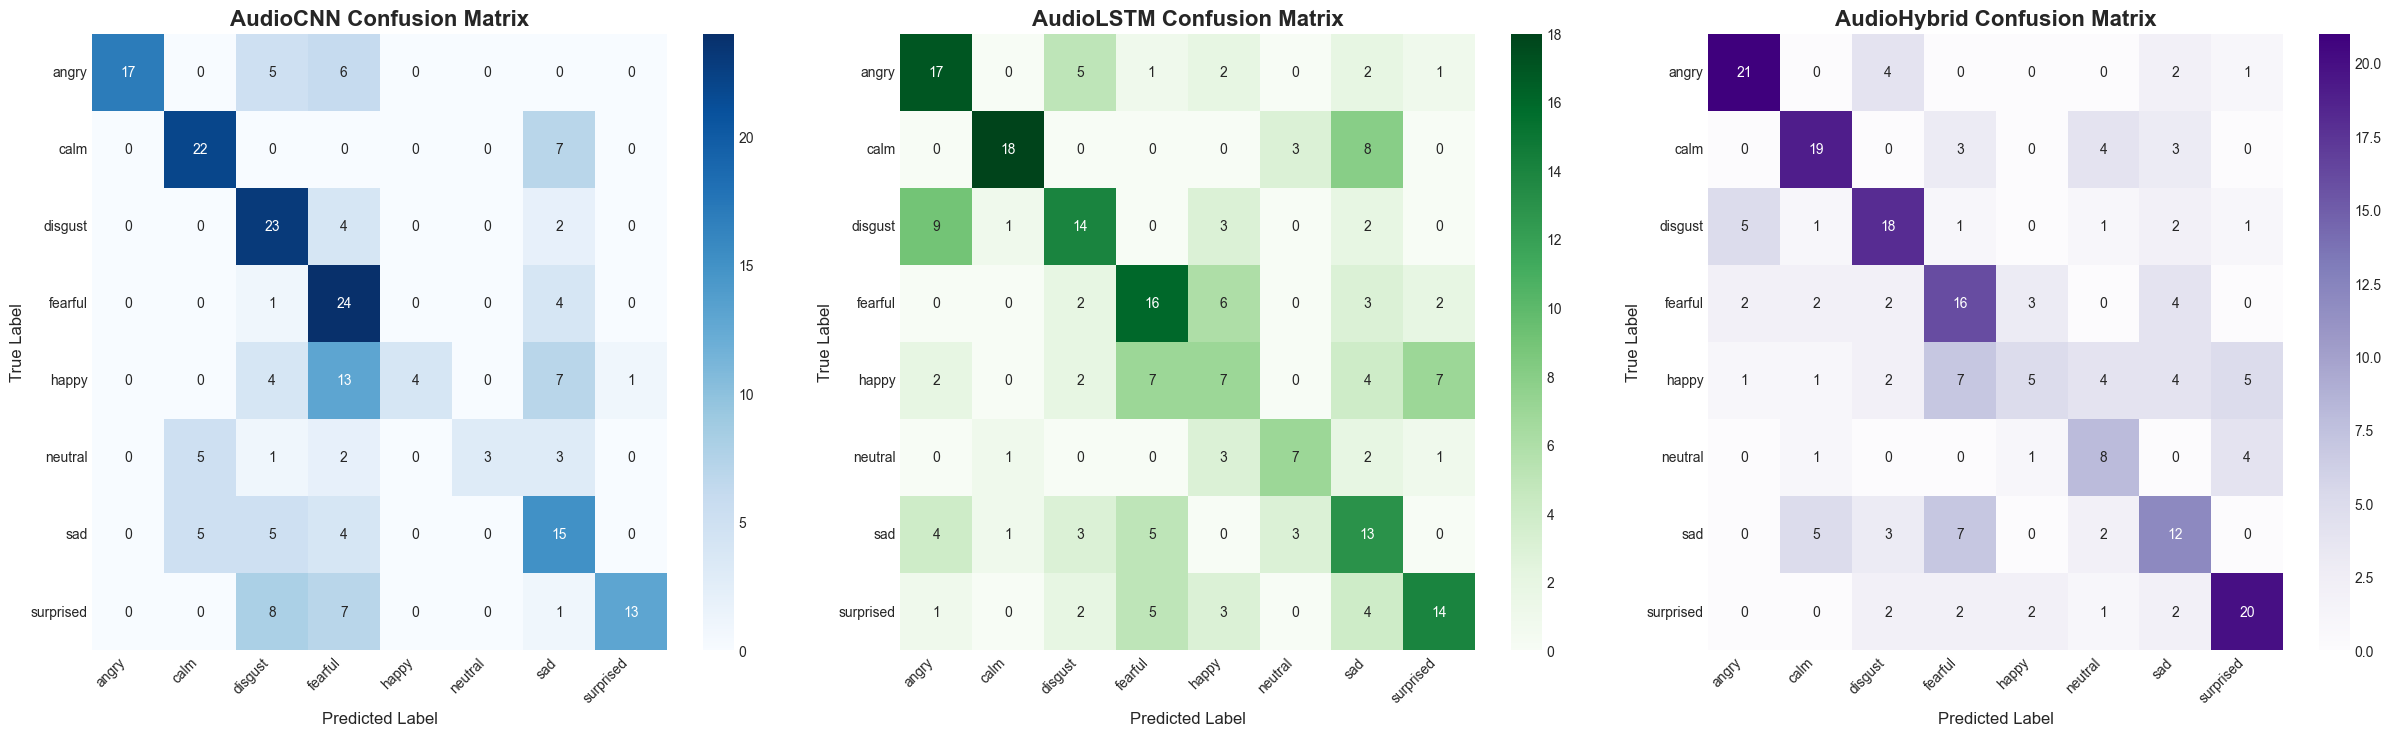


--- 4. Combined Multi-class ROC Curves for All Models ---


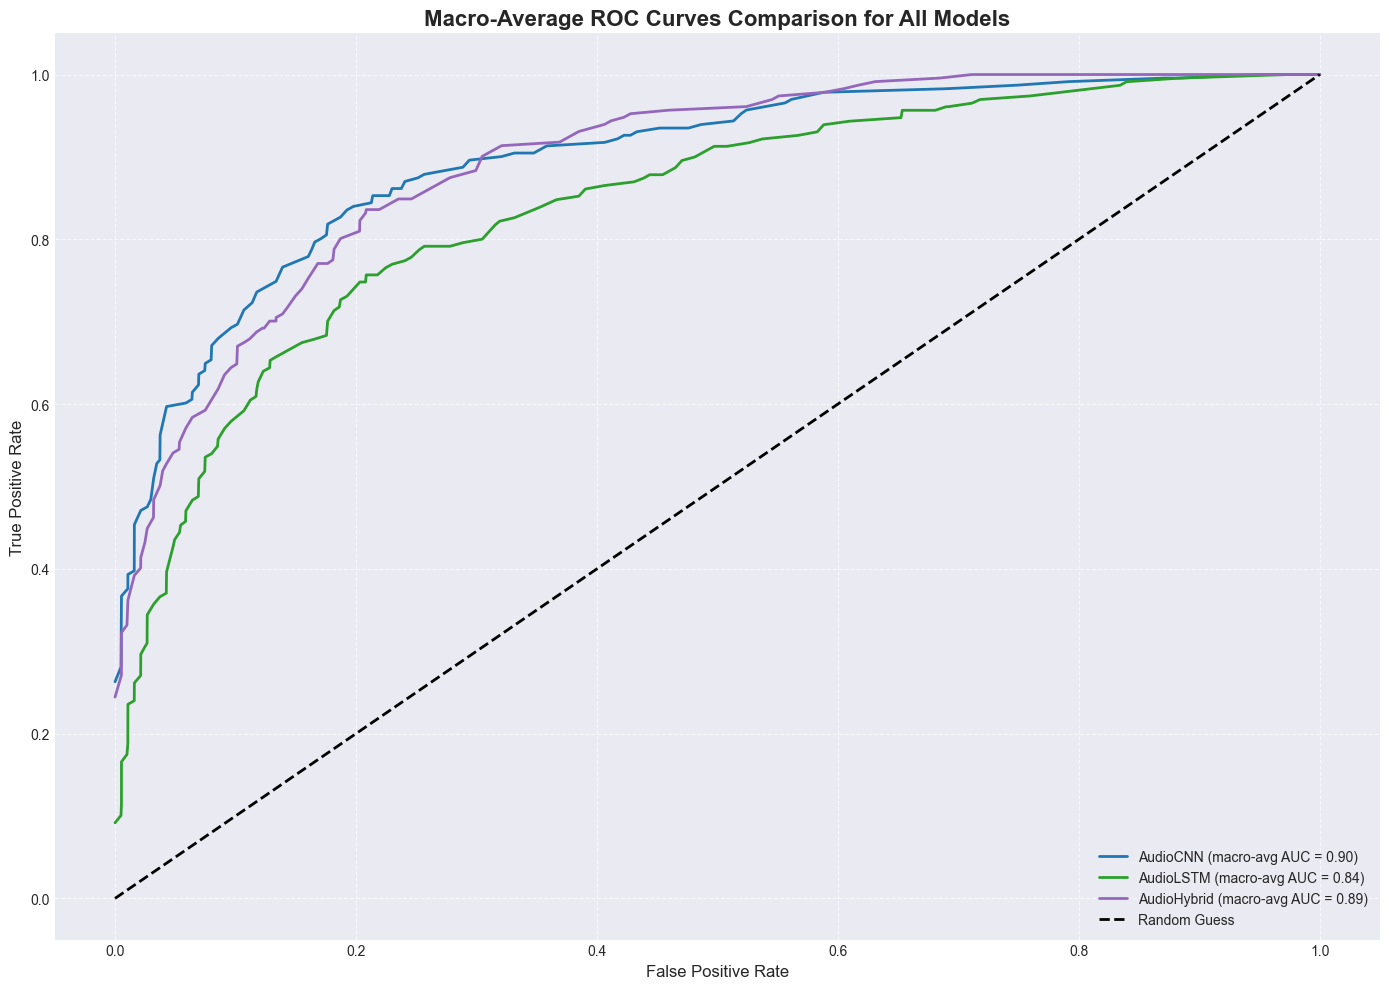


--- CONSOLIDATED BLOCK 5: Comparison Visualization Complete ---
All models have been trained and their performances compared visually and numerically.
This concludes the project's rework and expansion.


In [4]:
print("\n" + "="*80)
print("--- CONSOLIDATED BLOCK 5: Comparison Visualization ---")
print("="*80)

# --- 1. Compare Training & Validation Loss/Accuracy Curves ---
print("\n--- 1. Comparing Training & Validation Curves Across Models ---")

plt.figure(figsize=(18, 6))

# Subplot 1: Training & Validation Loss Comparison
plt.subplot(1, 2, 1)
plt.plot(cnn_train_losses, label='CNN Train Loss', color='#1f77b4', linestyle='-')
plt.plot(cnn_val_losses, label='CNN Val Loss', color='#ff7f0e', linestyle='--')
plt.plot(lstm_train_losses, label='LSTM Train Loss', color='#2ca02c', linestyle='-')
plt.plot(lstm_val_losses, label='LSTM Val Loss', color='#d62728', linestyle='--')
plt.plot(hybrid_train_losses, label='Hybrid Train Loss', color='#9467bd', linestyle='-')
plt.plot(hybrid_val_losses, label='Hybrid Val Loss', color='#8c564b', linestyle='--')
plt.title('Training and Validation Loss Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, max(max(cnn_train_losses), max(cnn_val_losses), max(lstm_train_losses), max(lstm_val_losses), max(hybrid_train_losses), max(hybrid_val_losses)) * 1.05)


# Subplot 2: Training & Validation Accuracy Comparison
plt.subplot(1, 2, 2)
plt.plot(cnn_train_accs, label='CNN Train Acc', color='#1f77b4', linestyle='-')
plt.plot(cnn_val_accs, label='CNN Val Acc', color='#ff7f0e', linestyle='--')
plt.plot(lstm_train_accs, label='LSTM Train Acc', color='#2ca02c', linestyle='-')
plt.plot(lstm_val_accs, label='LSTM Val Acc', color='#d62728', linestyle='--')
plt.plot(hybrid_train_accs, label='Hybrid Train Acc', color='#9467bd', linestyle='-')
plt.plot(hybrid_val_accs, label='Hybrid Val Acc', color='#8c564b', linestyle='--')
plt.title('Training and Validation Accuracy Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1.05) # Accuracy is usually between 0 and 1
plt.tight_layout(pad=3.0)
plt.show()

# --- 2. Summary of Final Test Accuracies ---
print("\n--- 2. Summary of Final Test Accuracies ---")
model_accuracies = {
    "AudioCNN": cnn_test_accuracy,
    "AudioLSTM": lstm_test_accuracy,
    "AudioHybrid": hybrid_test_accuracy
}

accuracy_df = pd.DataFrame(model_accuracies.items(), columns=['Model', 'Test Accuracy'])
accuracy_df = accuracy_df.sort_values(by='Test Accuracy', ascending=False)

print("\nOverall Test Accuracies:")
print(accuracy_df)

plt.figure(figsize=(9, 6))
sns.barplot(x='Model', y='Test Accuracy', data=accuracy_df, palette='pastel')
plt.title('Comparison of Model Test Accuracies', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.ylim(0, 1)
for index, row in accuracy_df.iterrows():
    plt.text(index, row['Test Accuracy'] + 0.02, f"{row['Test Accuracy']:.4f}", color='black', ha="center", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 3. Side-by-Side Confusion Matrices ---
print("\n--- 3. Side-by-Side Confusion Matrices ---")
# Get confusion matrices for all models
cm_cnn = confusion_matrix(cnn_true_labels, cnn_predictions)
cm_lstm = confusion_matrix(lstm_true_labels, lstm_predictions)
cm_hybrid = confusion_matrix(hybrid_true_labels, hybrid_predictions)

fig, axes = plt.subplots(1, 3, figsize=(25, 8)) # 1 row, 3 columns

sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_class_names, yticklabels=emotion_class_names, ax=axes[0])
axes[0].set_title('AudioCNN Confusion Matrix', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
# Corrected: Use set_xticklabels with rotation and ha
axes[0].set_xticklabels(emotion_class_names, rotation=45, ha='right', fontsize=10)
axes[0].set_yticklabels(emotion_class_names, rotation=0, fontsize=10)


sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', xticklabels=emotion_class_names, yticklabels=emotion_class_names, ax=axes[1])
axes[1].set_title('AudioLSTM Confusion Matrix', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
# Corrected: Use set_xticklabels with rotation and ha
axes[1].set_xticklabels(emotion_class_names, rotation=45, ha='right', fontsize=10)
axes[1].set_yticklabels(emotion_class_names, rotation=0, fontsize=10)


sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Purples', xticklabels=emotion_class_names, yticklabels=emotion_class_names, ax=axes[2])
axes[2].set_title('AudioHybrid Confusion Matrix', fontsize=16, fontweight='bold')
axes[2].set_xlabel('Predicted Label', fontsize=12)
axes[2].set_ylabel('True Label', fontsize=12)
# Corrected: Use set_xticklabels with rotation and ha
axes[2].set_xticklabels(emotion_class_names, rotation=45, ha='right', fontsize=10)
axes[2].set_yticklabels(emotion_class_names, rotation=0, fontsize=10)

plt.tight_layout(pad=3.0)
plt.show()


# --- 4. Combined Multi-class ROC Curves ---
print("\n--- 4. Combined Multi-class ROC Curves for All Models ---")

plt.figure(figsize=(14, 10))
# Plotting micro-average or macro-average ROC would be good,
# but for simplicity and comparison, let's plot for a few key classes or just macro.
# Let's do a macro-average ROC for all models for a cleaner comparison if needed.

# We already have all_probas_np for CNN, LSTM, Hybrid from evaluate_model function.
# Let's calculate macro-average ROC for each model
all_labels_binarized = label_binarize(cnn_true_labels, classes=range(num_audio_classes)) # True labels are the same for all tests

# Function to compute macro-average ROC curve
def plot_macro_roc(model_name, all_labels_binarized, all_probas_np, num_classes, color):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probas_np[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr_micro, tpr_micro, _ = roc_curve(all_labels_binarized.ravel(), all_probas_np.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= num_classes

    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)

    plt.plot(fpr_macro, tpr_macro,
             label=f'{model_name} (macro-avg AUC = {roc_auc_macro:.2f})',
             color=color, linewidth=2)

# Plot macro-average ROC for each model
plot_macro_roc("AudioCNN", all_labels_binarized, np.array(cnn_probas), num_audio_classes, '#1f77b4')
plot_macro_roc("AudioLSTM", all_labels_binarized, np.array(lstm_probas), num_audio_classes, '#2ca02c')
plot_macro_roc("AudioHybrid", all_labels_binarized, np.array(hybrid_probas), num_audio_classes, '#9467bd')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Macro-Average ROC Curves Comparison for All Models', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("--- CONSOLIDATED BLOCK 5: Comparison Visualization Complete ---")
print("All models have been trained and their performances compared visually and numerically.")
print("This concludes the project's rework and expansion.")
print("="*80)